<a href="https://colab.research.google.com/github/jon-chun/sentimentarcs/blob/main/sentiment_arcs_crux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Arcs: Self-Supervising Time Series Sentiment Analysis**

* Select Novel (Either precleaned in corpus or clean/upload new novel with defined format)

* Run Ensemble Models against the Novel to Generate SentimentArcs (Time Series)

* Smooth/Standardize SentimentArcs

* (less work: visual) Visual EDA of Variety Plots: SentimentArc (Start/End, Min/Max, Model Noise, MultiModel Consensus)

* Analysis Guidelines: MultiModel Agreements (Arc/Crux), Ensemble Baseline for Synthetic Ground Truth, Prioritize Lexical Models given extra weight as Explainable Baseline, Prioritize SOTA Models like RoBERTa, Anomalous Coherent Subgroups (esp if SOTA), look for spans of unusuall model dis/agreement

* (more work: close reading) Visual EDA of Variety Plots for Crux Points (Crux and Context both Single and MultiModel)

* Look for Motifs: Table Tops, Shoulders, Flairs, Narrowing


  (Crux and Arc Verfication)



## [MANUAL INPUT] Connect to Google gDrive 

In [1]:
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


# **Setup and Configuration**

In [2]:
%cd /gdrive/MyDrive/research/2021/sentiment_arcs/

/gdrive/MyDrive/research/2021/sentiment_arcs


In [3]:
!ls

crux				sentiment_arcs
data				sentiment_arcs_cruxes
nlp_sa_dl_novels_20211126.gdoc	sentiment_arcs_dataset
nlp_sa_dl_novels.gdoc		sentiment_arcs_emotions
novels				sentiment_arcs_features
plots				sentiment_arcs_segmentation
sa_time_series_20210912.gdoc


In [4]:
# CUSTOMIZE: define subdirectory paths

data_raw_subdir  = './data/sentiments_raw/'
data_clean_subdir  = './data/sentiments_clean/'
plots_subdir = './plots/'
crux_subdir = './crux/'
code_subdir  = './sentiment_arcs/sentiment_arcs/'

## Install Libraries

## Load Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
import re
from datetime import datetime
import glob

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [8]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [130]:
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy import signal
from scipy.signal import argrelextrema

In [9]:
plt.rcParams["figure.figsize"]=(20,10)

In [10]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/lowess.html
"""
import pylab
import statsmodels.api as sm

sns.set_style("whitegrid")

pylab.rc("figure", figsize=(16, 8))
pylab.rc("font", size=14)
"""

'\nimport pylab\nimport statsmodels.api as sm\n\nsns.set_style("whitegrid")\n\npylab.rc("figure", figsize=(16, 8))\npylab.rc("font", size=14)\n'

## Configure Jupyter Notebook

In [11]:
# Automatically reload changed libraries

# https://switowski.com/blog/ipython-autoreload
# import importlib
# importlib.reload(sentiment_arcs_utils.get_fullpath)

%load_ext autoreload
%autoreload 2

In [12]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from ipywidgets import widgets, interactive

# Configure Google Colab

# %load_ext google.colab.data_table

In [14]:
from IPython.display import Image

In [15]:
  from google.colab import files

# **Utility Functions**

In [16]:
!pwd

/gdrive/MyDrive/research/2021/sentiment_arcs


In [17]:
!ls

crux				sentiment_arcs
data				sentiment_arcs_cruxes
nlp_sa_dl_novels_20211126.gdoc	sentiment_arcs_dataset
nlp_sa_dl_novels.gdoc		sentiment_arcs_emotions
novels				sentiment_arcs_features
plots				sentiment_arcs_segmentation
sa_time_series_20210912.gdoc


In [18]:
# Add sentiment_arcs.py to the sys path in order to import library

import sys

# sys.path.append('/content/gdrive/mypythondirectory')

sys.path.append('/gdrive/My Drive/research/2021/sentiment_arcs/sentiment_arcs')

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/gdrive/My Drive/research/2021/sentiment_arcs/sentiment_arcs']

In [19]:
!ls sentiment_arcs/*.py

sentiment_arcs/sentiment_arcs_utils.py


In [20]:
# import importlib

# importlib.reload(get_fullpath)


In [21]:
# %aimport sentiment_arcs_utils

In [22]:
# from sentiment_arcs_utils import get_fullpath

In [23]:
# ??get_fullpath

In [160]:
def get_fullpath( ftype='data_clean', first_note = '',last_note='', plot_ext='png', no_date=False):
  '''
  Given a required file_type(ftype:['data_clean','data_raw','plot']) and
    optional first_note: str inserted after Title and before (optional) SMA/Standardization info
             last_note: str insterted after (optional) SMA/Standardization info and before (optional) timedate stamp
             plot_ext: change default *.png extension of plot file
             no_date: don't add trailing datetime stamp to filename
  Generate and return a fullpath (/subdir/filename.ext) to save file to
  '''

  # String with full path/filename.ext to return
  fname = ''

  # Get current datetime stamp as a string
  if no_date:
    date_dt = ''
  else:
    date_dt = f'_{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}'

  # Clean optional file notation if passed in
  if first_note:
    fnote_str = first_note.replace(' ', '_')
    fnote_str = '_'.join(fnote_str.split())
    fnote_str = '_'.join(fnote_str.split('.'))
    fnote_str = '_'.join(fnote_str.split('__'))
    fnote_str = fnote_str.lower()

  # Get Current Novel Name and Clean
  novel_title_str = Novel_Title[0].replace(' ', '_').lower()
  novel_title_str = '_'.join(novel_title_str.split())
  novel_title_str = '_'.join(novel_title_str.split('.'))
  novel_title_str = '_'.join(novel_title_str.split('__'))
  if first_note:
    novel_title_str = f'{novel_title_str}_{first_note}'

  # Option (a): Cleaned Model Data (Smoothed then Standardized)
  if ftype == 'data_clean':
    subdir_path = data_clean_subdir
    fprefix = 'sa_clean_'
    fname_str = f'{subdir_path}{fprefix}{novel_title_str}_{Model_Standardization_Method.lower()}_sma{Window_Percent}'
    if last_note:
      fname = f'{fname_str}_{last_note}{date_dt}.csv'
    else:
      fname = f'{fname_str}{date_dt}.csv'

  # Option (b): Raw Model Data
  elif ftype == 'data_raw':
    subdir_path = data_raw_subdir
    fprefix = 'sa_raw_'
    fname_str = f'{subdir_path}{fprefix}{novel_title_str}'
    if last_note:
      fname = f'{fname_str}_{last_note}{date_dt}.csv'
    else:
      fname = f'{fname_str}{date_dt}.csv'

  # Option (c): Plot Figure
  elif ftype == 'plot':
    subdir_path = plots_subdir
    fprefix = 'plot_'
    fname_str = f'{subdir_path}{fprefix}{novel_title_str}'
    if last_note:
      fname = f'{fname_str}_{last_note}{date_dt}.{plot_ext}'
    else:
      fname = f'{fname_str}{date_dt}.{plot_ext}'

  # Option (d): Crux Text
  elif ftype == 'crux_text':
    subdir_path = crux_subdir
    fprefix = 'crux_'
    fname_str = f'{subdir_path}{fprefix}{novel_title_str}'
    if last_note:
      fname = f'{fname_str}_{last_note}{date_dt}.txt'
    else:
      fname = f'{fname_str}{date_dt}.txt'

  else:
    print(f'ERROR: In get_fullpath() with illegal arg ftype:[{ftype}]')
    return f'ERROR: ftype:[{ftype}]'

  return fname


In [25]:
# Test

# NameError: name 'Novel_Title' is not defined

# get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)

# **Select Novels**

## Choose from Preexisting Corpus

In [26]:
novels_dt = {
  'cdickens_christmascarol':['A Christmas Carol by Charles Dickens ',1843,1399],
  'cdickens_greatexpectations':['Great Expectations by Charles Dickens' ,1861, 7230],
  'ddefoe_robinsoncrusoe':['Robinson Crusoe by Daniel Defoe',1719, 2280],
  'emforester_howardsend':['Howards End by E.M. Forester', 1910, 8999],
  'fbaum_wizardofoz':['The Wonderful Wizard of Oz by Frank Baum', 1850, 2238],
  'fdouglass_narrativeofslave':['Narrative of the life of Frederick Douglass, an American Slave by Frederick Douglass', 1845, 1688],
  'fscottfitzerald_greatgatsby':['The Great Gatsby by F. Scott Fitzgerald', 1925, 2950],
  'geliot_middlemarch':['Middlemarch by George Eliot', 1871, 10373],
  'hjames_portraitofalady':['The Portrait of a Lady by Henry James', 1881, 13258],
  'homerwilson_homer':['The Odyssey by Homer (trans Emily Wilson)', 2018, 6814],
  'imcewan_machineslikeme':['Machines Like Me by Ian McEwan', 2019, 6448],
  'jausten_prideandprejudice':['Pride and Prejudice by Jane Austen', 1813, 5891],
  'jconrad_heartofdarkness':['Heart of Darkness by Joseph Conrad', 1902, 1619],
  'jjoyce_portraitoftheartist':['A Portrait of the Artist as a Young Man by James Joyce', 2016, 5584],
  'jkrowling_pottersorcerersstone':['Harry Potter and the Sorcerer’s Stone by J.K. Rowling ', 1997, 5488],
  'mproust_searchoflosttime':['In Search of Lost Time, Vol 3: The Guermantes Way by Marcel Proust', 1920, 8388],
  'mshelly_frankenstein':['Frankenstein by Mary Shelly', 1818, 3282],
  'mtwain_huckleberryfinn':['Huckleberry Finn by Mark Twain', 1884, 5775],
  'staugustine_confessions':['Confessions (Books 1-9) by St. Augustine', 400, 3673],
  'tmorrison_beloved':['Beloved by Toni Morrison', 1987, 7102],
  'vnabokov_palefire':['Pale Fire by Viktor Nabokov', 1962, 2984],
  'vwoolf_mrsdalloway':['Mrs. Dalloway by Virginia Woolf', 1925, 3647],
  'vwoolf_orlando':['Orlando by Virginia Woolf', 1928, 2,992],
  'vwoolf_thewaves':['The Waves by Virginia Woolf', 1931, 3919],
  'vwoolf_tothelighthouse':['To The Lighthouse by Virginia Woolf', 1927, 3403],
}

In [27]:
# Derive List of Novel a)keys and b)full author and titles

novels_corpus_ls = list(novels_dt.keys())
print(f'\nNovel Columns:')
for akey in novels_corpus_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNovel Titles:')
novels_full_ls = [x[0] for x in list(novels_dt.values())]
for akey in novels_full_ls:
  print(f'  {akey}')


Novel Columns:
  cdickens_christmascarol
  cdickens_greatexpectations
  ddefoe_robinsoncrusoe
  emforester_howardsend
  fbaum_wizardofoz
  fdouglass_narrativeofslave
  fscottfitzerald_greatgatsby
  geliot_middlemarch
  hjames_portraitofalady
  homerwilson_homer
  imcewan_machineslikeme
  jausten_prideandprejudice
  jconrad_heartofdarkness
  jjoyce_portraitoftheartist
  jkrowling_pottersorcerersstone
  mproust_searchoflosttime
  mshelly_frankenstein
  mtwain_huckleberryfinn
  staugustine_confessions
  tmorrison_beloved
  vnabokov_palefire
  vwoolf_mrsdalloway
  vwoolf_orlando
  vwoolf_thewaves
  vwoolf_tothelighthouse



Novel Titles:
  A Christmas Carol by Charles Dickens 
  Great Expectations by Charles Dickens
  Robinson Crusoe by Daniel Defoe
  Howards End by E.M. Forester
  The Wonderful Wizard of Oz by Frank Baum
  Narrative of the life of Frederick Douglass, an American Slave by Frederick Douglass
  The Great Gatsby by F. Scott Fitzgerald
  Middlemarch by George Eliot
  The Port

In [28]:
#@title CORPORA: Select Which Novel(s) you want to Analyze:

cdickens_christmascarol = True #@param {type:"boolean"}
cdickens_greatexpectations = True #@param {type:"boolean"}
ddefoe_robinsoncrusoe = False #@param {type:"boolean"}
emforester_howardsend = False #@param {type:"boolean"}
fbaum_wizardofoz = False #@param {type:"boolean"}
fdouglass_narrativeofslave = False #@param {type:"boolean"}
fscottfitzerald_greatgatsby = False #@param {type:"boolean"}
geliot_middlemarch = False #@param {type:"boolean"}
hjames_portraitofalady = False #@param {type:"boolean"}
homerwilson_homer = False #@param {type:"boolean"}
imcewan_machineslikeme = False #@param {type:"boolean"}
jausten_prideandprejudice = False #@param {type:"boolean"}
jconrad_heartofdarkness = False #@param {type:"boolean"}
jjoyce_portraitoftheartist = False #@param {type:"boolean"}
jkrowling_pottersorcerersstone = False #@param {type:"boolean"}
mproust_searchoflosttime = False #@param {type:"boolean"}
mshelly_frankenstein = False #@param {type:"boolean"}
mtwain_huckleberryfinn = False #@param {type:"boolean"}
staugustine_confessions = False #@param {type:"boolean"}
tmorrison_beloved = True #@param {type:"boolean"}
vnabokov_palefire = False #@param {type:"boolean"}
vwoolf_mrsdalloway = True #@param {type:"boolean"}
vwoolf_orlando = True #@param {type:"boolean"}
vwoolf_thewaves = True #@param {type:"boolean"}
vwoolf_tothelighthouse = True #@param {type:"boolean"}

novels_subcorpus_ls = []

if cdickens_christmascarol:
  novels_subcorpus_ls.append('cdickens_christmascarol')
if cdickens_greatexpectations: 
  novels_subcorpus_ls.append('cdickens_greatexpectations')
if ddefoe_robinsoncrusoe:
  novels_subcorpus_ls.append('ddefoe_robinsoncrusoe')
if emforester_howardsend:
  novels_subcorpus_ls.append('emforester_howardsend')
if fbaum_wizardofoz:
  novels_subcorpus_ls.append('fbaum_wizardofoz')
if fdouglass_narrativeofslave:
  novels_subcorpus_ls.append('fdouglass_narrativeofslave')
if fscottfitzerald_greatgatsby:
  novels_subcorpus_ls.append('fscottfitzerald_greatgatsby')
if geliot_middlemarch:
  novels_subcorpus_ls.append('geliot_middlemarch')
if hjames_portraitofalady:
  novels_subcorpus_ls.append('hjames_portraitofalady')
if homerwilson_homer:
  novels_subcorpus_ls.append('homerwilson_homer')
if imcewan_machineslikeme:
  novels_subcorpus_ls.append('imcewan_machineslikeme')
if jausten_prideandprejudice:
  novels_subcorpus_ls.append('jausten_prideandprejudice')
if jconrad_heartofdarkness:
  novels_subcorpus_ls.append('jconrad_heartofdarkness')
if jjoyce_portraitoftheartist:
  novels_subcorpus_ls.append('jjoyce_portraitoftheartist')
if jkrowling_pottersorcerersstone:
  novels_subcorpus_ls.append('jkrowling_pottersorcerersstone')
if mproust_searchoflosttime:
  novels_subcorpus_ls.append('mproust_searchoflosttime')
if mshelly_frankenstein:
  novels_subcorpus_ls.append('mshelly_frankenstein')
if mtwain_huckleberryfinn:
  novels_subcorpus_ls.append('mtwain_huckleberryfinn')
if staugustine_confessions:
  novels_subcorpus_ls.append('staugustine_confessions')
if tmorrison_beloved:
  novels_subcorpus_ls.append('tmorrison_beloved')
if vnabokov_palefire:
  novels_subcorpus_ls.append('vnabokov_palefire')
if vwoolf_mrsdalloway:
  novels_subcorpus_ls.append('vwoolf_mrsdalloway')
if vwoolf_orlando:
  novels_subcorpus_ls.append('vwoolf_orlando')
if vwoolf_thewaves:
  novels_subcorpus_ls.append('vwoolf_thewaves')
if vwoolf_tothelighthouse:
  novels_subcorpus_ls.append('vwoolf_tothelighthouse')


In [29]:
# Confirm Novel Selection(s)

print(f'Confirm these are the Novels you want to analyze:\n')

for i, anovel in enumerate(novels_subcorpus_ls):
  print(f'  Novel #{i}: {novels_dt[anovel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the Novels you want to analyze:

  Novel #0: A Christmas Carol by Charles Dickens 
  Novel #1: Great Expectations by Charles Dickens
  Novel #2: Beloved by Toni Morrison
  Novel #3: Mrs. Dalloway by Virginia Woolf
  Novel #4: Orlando by Virginia Woolf
  Novel #5: The Waves by Virginia Woolf
  Novel #6: To The Lighthouse by Virginia Woolf

If there is an error, go back and rerun the previous code cell.


In [30]:
#@title Enter ONE Novel to Focus On:

Novel_Key = "vwoolf_tothelighthouse" #@param {type:"string"}

# novels_ls = [Novel_Key]

# Novel_Title = novels_dt[novels_ls[0]]
# Novel_Title

Novel_Title = novels_dt[Novel_Key][0]

novel_focus_str = Novel_Key

In [31]:
Novel_Title

'To The Lighthouse by Virginia Woolf'

## Review Summary of Selected Novel(s)

In [32]:
# Review Summary of Novel Selections (at Corpus, SubCorpus and Individual Levels):

print(f'\nCorpus: All Novels (novels_corpus_ls):')
for i, anovel in enumerate(novels_corpus_ls):
  print(f'  Novel #{i}: {anovel}')

print(f'\nSubCorpus: Only Selected Novels (novels_subcorpus_ls):')
for i,anovel in enumerate(novels_subcorpus_ls):
  print(f'  Novel #{i}: {anovel}')

print(f'\nFocus: One Novel to Focus On (novels_focus_str):')
print(f'  {novel_focus_str}')


Corpus: All Novels (novels_corpus_ls):
  Novel #0: cdickens_christmascarol
  Novel #1: cdickens_greatexpectations
  Novel #2: ddefoe_robinsoncrusoe
  Novel #3: emforester_howardsend
  Novel #4: fbaum_wizardofoz
  Novel #5: fdouglass_narrativeofslave
  Novel #6: fscottfitzerald_greatgatsby
  Novel #7: geliot_middlemarch
  Novel #8: hjames_portraitofalady
  Novel #9: homerwilson_homer
  Novel #10: imcewan_machineslikeme
  Novel #11: jausten_prideandprejudice
  Novel #12: jconrad_heartofdarkness
  Novel #13: jjoyce_portraitoftheartist
  Novel #14: jkrowling_pottersorcerersstone
  Novel #15: mproust_searchoflosttime
  Novel #16: mshelly_frankenstein
  Novel #17: mtwain_huckleberryfinn
  Novel #18: staugustine_confessions
  Novel #19: tmorrison_beloved
  Novel #20: vnabokov_palefire
  Novel #21: vwoolf_mrsdalloway
  Novel #22: vwoolf_orlando
  Novel #23: vwoolf_thewaves
  Novel #24: vwoolf_tothelighthouse

SubCorpus: Only Selected Novels (novels_subcorpus_ls):
  Novel #0: cdickens_christma

## Upload New Novel

In [33]:
# TODO: Coming feature

# **Select Sentiment Analysis Models**

In [34]:
cols_map_dt = {'syuzhet':'syuzhetr',
               'huliu':'bing_sentimentr',
               'sentiword':'sentiword_sentimentr',
               'senticnet':'senticnet_sentimentr',
               'lmcd':'lmcd_sentimentr',
               'jockers':'jockers_sentimentr',
               'jockers_rinker':'jockersrinker_sentimentr'
               }

cols_missing_ls = ['nrc_sentimentr']

In [35]:
models_dt = {
    # Lexicon
    'SyuzhetR_AFINN':['afinn', 'lexicon', 2477],
    'SyuzhetR_Bing':['bing', 'lexicon', 5469],
    'SyuzhetR_NRC':['nrc', 'lexicon', 5468],
    'SyuzhetR_SyuzhetR':['syuzhetr', 'lexicon', 10748],
    'SentimentR_SentimentR':['sentimentr', 'lexicon', 11710],
    'Pattern':['pattern', 'lexicon', 2918],

    # Heuristic
    'VADER':['vader', 'heuristic', 7520],
    'SentimentR_Bing':['bing_sentimentr', 'heuristic', 5469],
    # 'SentimentR_NRC':['nrc_sentimentr', 'heuristic', 5469],
    'SentimentR_SentiWord':['sentiword_sentimentr', 'heuristic', 20093],
    'SentimentR_SenticNet':['senticnet_sentimentr', 'heuristic', 23626],
    'SentimentR_LMcD':['lmcd_sentimentr', 'heuristic', 4150],
    'SentimentR_Jockers':['jockers_sentimentr', 'heuristic', 10748],
    'SentimentR_JockersRinker':['jockersrinker_sentimentr', 'heuristic', 11710],

    # Traditional ML 
    'Logistic_Regression':['logreg', 'tradml', 'scikit'],
    'Logistic_Regression_CV':['logreg_cv', 'tradml', 'scikit'],
    'Multinomial_Naive_Bayes':['multinb', 'tradml', 'scikit'],
    'TextBlob':['textblob', 'tradml', 'textblob'],
    'Random_Forest':['rf', 'tradml', 'scikit'],
    'XGBoost':['xgb', 'tradml', 'xgboost'],
    'FLAML_AutoML':['flaml', 'tradml', 'flaml'],
    'AutoGluon_Text':['autogluon', 'tradml', 'autogluon_text'],

    # DNN
    'Fully_Connected_Network':['fcn', 'dnn', 6287671],
    'LSTM_DNN':['lstm', 'dnn', 7109089],
    'CNN_DNN':['cnn', 'dnn', 1315937],
    'Multilingual_CNN_Stanza_AutoML':['stanza', 'dnn', 0],
    'HyperOpt_CNN_Flair_AutoML':['flair', 'dnn', 0],

    # Transformer
    'Distilled_BERT':['huggingface', 'transformer', 'bert'],
    'T5_IMDB':['t5imdb50k', 'transformer', 't5'],
    'BERT_Dual_Coding':['hinglish', 'transformer', 'bert'],
    'BERT_Yelp':['yelp', 'transformer', 'bert'],
    'BERT_2IMDB':['imdb2way', 'transformer', 'bert'],
    'BERT_Multilingual':['nlptown', 'transformer', 'bert'],
    'RoBERTa_XML_8Language':['robertaxml8lang', 'transformer', 'roberta'],
    'RoBERTa_Large_15DB':['roberta15lg', 'transformer', 'roberta'],

}

In [36]:
# Convenience lists for each type of model

# Lexicon Models
models_lexicon_ls = [x[0] for x in models_dt.values() if x[1] == 'lexicon']
print(f'\nThere are {len(models_lexicon_ls)} Lexicon Models')
for i,amodel in enumerate(models_lexicon_ls):
  print(f'  Lexicon Model #{i}: {amodel}')

# Heuristic Models
models_heuristic_ls = [x[0] for x in models_dt.values() if x[1] == 'heuristic']
print(f'\nThere are {len(models_heuristic_ls)} Heuristic Models')
for i,amodel in enumerate(models_heuristic_ls):
  print(f'  Heuristic Model #{i}: {amodel}')

# Traditional ML Models
models_tradml_ls = [x[0] for x in models_dt.values() if x[1] == 'tradml']
print(f'\nThere are {len(models_tradml_ls)} Traditional ML Models')
for i,amodel in enumerate(models_tradml_ls):
  print(f'  Traditional ML Model #{i}: {amodel}')

# DNN Models
models_dnn_ls = [x[0] for x in models_dt.values() if x[1] == 'dnn']
print(f'\nThere are {len(models_dnn_ls)} DNN Models')
for i,amodel in enumerate(models_dnn_ls):
  print(f'  DNN Model #{i}: {amodel}')

# Transformer Models
models_transformer_ls = [x[0] for x in models_dt.values() if x[1] == 'transformer']
print(f'\nThere are {len(models_transformer_ls)} Transformer Models')
for i,amodel in enumerate(models_transformer_ls):
  print(f'  Transformer Model #{i}: {amodel}')

# All Models

"""
models_all_ls = models_lexicon_ls + models_heuristic_ls + models_tradml_ls + models_dnn_ls + models_transformer_ls

print(f'\nThere are {len(cols_models_ls)} Total Models:')
for i,amodel in enumerate(cols_models_ls):
  print(f'  Model #{i:>2}: {amodel}')
""";

models_ensemble_ls = models_lexicon_ls + models_heuristic_ls + models_tradml_ls + models_dnn_ls + models_transformer_ls

print(f'\nThere are {len(models_ensemble_ls)} Total Models:')
for i,amodel in enumerate(models_ensemble_ls):
  print(f'  Model #{i:>2}: {amodel}')

print(f'\nThere are {len(models_ensemble_ls)} Total Models (+ 1 for Ensemble Median)')


There are 6 Lexicon Models
  Lexicon Model #0: afinn
  Lexicon Model #1: bing
  Lexicon Model #2: nrc
  Lexicon Model #3: syuzhetr
  Lexicon Model #4: sentimentr
  Lexicon Model #5: pattern

There are 7 Heuristic Models
  Heuristic Model #0: vader
  Heuristic Model #1: bing_sentimentr
  Heuristic Model #2: sentiword_sentimentr
  Heuristic Model #3: senticnet_sentimentr
  Heuristic Model #4: lmcd_sentimentr
  Heuristic Model #5: jockers_sentimentr
  Heuristic Model #6: jockersrinker_sentimentr

There are 8 Traditional ML Models
  Traditional ML Model #0: logreg
  Traditional ML Model #1: logreg_cv
  Traditional ML Model #2: multinb
  Traditional ML Model #3: textblob
  Traditional ML Model #4: rf
  Traditional ML Model #5: xgb
  Traditional ML Model #6: flaml
  Traditional ML Model #7: autogluon

There are 5 DNN Models
  DNN Model #0: fcn
  DNN Model #1: lstm
  DNN Model #2: cnn
  DNN Model #3: stanza
  DNN Model #4: flair

There are 8 Transformer Models
  Transformer Model #0: hugging

"\nmodels_all_ls = models_lexicon_ls + models_heuristic_ls + models_tradml_ls + models_dnn_ls + models_transformer_ls\n\nprint(f'\nThere are {len(cols_models_ls)} Total Models:')\nfor i,amodel in enumerate(cols_models_ls):\n  print(f'  Model #{i:>2}: {amodel}')\n"


There are 34 Total Models:
  Model # 0: afinn
  Model # 1: bing
  Model # 2: nrc
  Model # 3: syuzhetr
  Model # 4: sentimentr
  Model # 5: pattern
  Model # 6: vader
  Model # 7: bing_sentimentr
  Model # 8: sentiword_sentimentr
  Model # 9: senticnet_sentimentr
  Model #10: lmcd_sentimentr
  Model #11: jockers_sentimentr
  Model #12: jockersrinker_sentimentr
  Model #13: logreg
  Model #14: logreg_cv
  Model #15: multinb
  Model #16: textblob
  Model #17: rf
  Model #18: xgb
  Model #19: flaml
  Model #20: autogluon
  Model #21: fcn
  Model #22: lstm
  Model #23: cnn
  Model #24: stanza
  Model #25: flair
  Model #26: huggingface
  Model #27: t5imdb50k
  Model #28: hinglish
  Model #29: yelp
  Model #30: imdb2way
  Model #31: nlptown
  Model #32: robertaxml8lang
  Model #33: roberta15lg

There are 34 Total Models (+ 1 for Ensemble Median)


## Lexical Models

In [37]:
#@title Select Lexical Model(s) to Include in Ensemble:

SyzuhetR_AFINN = False #@param {type:"boolean"}
SyuzhetR_Bing = False #@param {type:"boolean"}
SyuzhetR_NRC = True #@param {type:"boolean"}
SyuzhetR_SyuzhetR = True #@param {type:"boolean"}
SentimentR_SentimentR = False #@param {type:"boolean"}
Pattern = False #@param {type:"boolean"}


ensemble_lexicon_ls = []

if SyzuhetR_AFINN:
  ensemble_lexicon_ls.append('SyuzhetR_AFINN')
if SyuzhetR_Bing:
  ensemble_lexicon_ls.append('SyuzhetR_Bing')
if SyuzhetR_NRC:
  ensemble_lexicon_ls.append('SyuzhetR_NRC')
if SyuzhetR_SyuzhetR:
  ensemble_lexicon_ls.append('SyuzhetR_SyuzhetR')
if SentimentR_SentimentR:
  ensemble_lexicon_ls.append('SentimentR_SentimentR')
if Pattern:
  ensemble_lexicon_ls.append('Pattern')


ensemble_lexicon_ls

['SyuzhetR_NRC', 'SyuzhetR_SyuzhetR']

In [38]:
# Confirm Lexicon Model Selection(s)

print(f'Confirm these are the Lexicon Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(ensemble_lexicon_ls):
  print(f'  Model #{i}: {models_dt[amodel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the Lexicon Model(s) to include in the Ensemble:

  Model #0: nrc
  Model #1: syuzhetr

If there is an error, go back and rerun the previous code cell.


## Heuristic Models

In [39]:
"""
for amodel in [x for x in models_dt.keys() if models_dt[x][1] == 'heuristic']:
  print(amodel)
""";

In [40]:
"""
for amodel in models_heuristic_ls:
  print(amodel)
""";

In [41]:
#@title Select Heuristic Model(s) to Include in Ensemble:

VADER = True #@param {type:"boolean"}
SentimentR_Bing = False #@param {type:"boolean"}
# SentimentR_NRC = True #@param {type:"boolean"}
SentimentR_SentiWord = False #@param {type:"boolean"}
SentimentR_SenticNet = False #@param {type:"boolean"}
SentimentR_LMcD = False #@param {type:"boolean"}
SentimentR_Jockers = False #@param {type:"boolean"}
SentimentR_JockersRinker = True #@param {type:"boolean"}


ensemble_heuristic_ls = []

if VADER:
  ensemble_heuristic_ls.append('VADER')
if SentimentR_Bing:
  ensemble_heuristic_ls.append('SentimentR_Bing')

# if SentimentR_NRC:
#   ensemble_heuristic_ls.append('SentimentR_NRC')

if SentimentR_SentiWord:
  ensemble_heuristic_ls.append('SentimentR_SentiWord')
if SentimentR_SenticNet:
  ensemble_heuristic_ls.append('SentimentR_SenticNet')
if SentimentR_LMcD:
  ensemble_heuristic_ls.append('SentimentR_LMcD')
if SentimentR_Jockers:
  ensemble_heuristic_ls.append('SentimentR_Jockers')
if SentimentR_JockersRinker:
  ensemble_heuristic_ls.append('SentimentR_JockersRinker')

ensemble_heuristic_ls

['VADER', 'SentimentR_JockersRinker']

In [42]:
# Confirm Heuristic Model Selection(s)

print(f'Confirm these are the Heuristic Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(ensemble_heuristic_ls):
  print(f'  Model #{i}: {models_dt[amodel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the Heuristic Model(s) to include in the Ensemble:

  Model #0: vader
  Model #1: jockersrinker_sentimentr

If there is an error, go back and rerun the previous code cell.


## Traditional ML Models

In [43]:
"""
for amodel in [x for x in models_dt.keys() if models_dt[x][1] == 'tradml']:
  print(amodel)
""";

In [44]:
"""
for amodel in models_tradml_ls:
  print(amodel)
""";

In [45]:
#@title Select Traditionl ML Model(s) to Include in Ensemble:

Logistic_Regression = True #@param {type:"boolean"}
Logistic_Regression_CV6 = False #@param {type:"boolean"}
Multinomial_Naive_Bayes = False #@param {type:"boolean"}
TextBlob = True #@param {type:"boolean"}
Random_Forest = False #@param {type:"boolean"}
XGBoost = True #@param {type:"boolean"}
FLAML_AutoML = True #@param {type:"boolean"}
AutoGluon_Text = True #@param {type:"boolean"}


ensemble_tradml_ls = []

if Logistic_Regression:
  ensemble_tradml_ls.append('Logistic_Regression')
if Logistic_Regression_CV6:
  ensemble_tradml_ls.append('Logistic_Regression_CV')
if Multinomial_Naive_Bayes:
  ensemble_tradml_ls.append('Multinomial_Naive_Bayes')
if TextBlob:
  ensemble_tradml_ls.append('TextBlob')
if Random_Forest:
  ensemble_tradml_ls.append('Random_Forest')
if XGBoost:
  ensemble_tradml_ls.append('XGBoost')
if FLAML_AutoML:
  ensemble_tradml_ls.append('FLAML_AutoML')
if AutoGluon_Text:
  ensemble_tradml_ls.append('AutoGluon_Text')

ensemble_tradml_ls

['Logistic_Regression',
 'TextBlob',
 'XGBoost',
 'FLAML_AutoML',
 'AutoGluon_Text']

In [46]:
# Confirm Traditional ML Model Selection(s)

print(f'Confirm these are the Traditional ML Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(ensemble_tradml_ls):
  print(f'  Model #{i}: {models_dt[amodel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the Traditional ML Model(s) to include in the Ensemble:

  Model #0: logreg
  Model #1: textblob
  Model #2: xgb
  Model #3: flaml
  Model #4: autogluon

If there is an error, go back and rerun the previous code cell.


## DNN Models

In [47]:
"""
for amodel in [x for x in models_dt.keys() if models_dt[x][1] == 'dnn']:
  print(amodel)
""";

In [48]:
"""
for amodel in models_dnn_ls:
  print(amodel)
""";

In [49]:
#@title Select Heuristic Model(s) to Include in Ensemble:

Fully_Connected_Network = True #@param {type:"boolean"}
LSTM_DNN = False #@param {type:"boolean"}
CNN_DNN = False #@param {type:"boolean"}
Multilingual_CNN_Stanza_AutoML = True #@param {type:"boolean"}
HyperOpt_CNN_Flair_AutoML = True #@param {type:"boolean"}


ensemble_dnn_ls = []

if Fully_Connected_Network:
  ensemble_dnn_ls.append('Fully_Connected_Network')
if LSTM_DNN:
  ensemble_dnn_ls.append('LSTM_DNN')
if CNN_DNN:
  ensemble_dnn_ls.append('CNN_DNN')
if Multilingual_CNN_Stanza_AutoML:
  ensemble_dnn_ls.append('Multilingual_CNN_Stanza_AutoML')
if HyperOpt_CNN_Flair_AutoML:
  ensemble_dnn_ls.append('HyperOpt_CNN_Flair_AutoML')

ensemble_dnn_ls

['Fully_Connected_Network',
 'Multilingual_CNN_Stanza_AutoML',
 'HyperOpt_CNN_Flair_AutoML']

In [50]:
# Confirm DNN Model Selection(s)

print(f'Confirm these are the DNN Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(ensemble_dnn_ls):
  print(f'  Model #{i}: {models_dt[amodel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the DNN Model(s) to include in the Ensemble:

  Model #0: fcn
  Model #1: stanza
  Model #2: flair

If there is an error, go back and rerun the previous code cell.


## Transformer Models

In [51]:
"""
for amodel in [x for x in models_dt.keys() if models_dt[x][1] == 'transformer']:
  print(amodel)
""";

In [52]:
"""
for amodel in models_transformer_ls:
  print(amodel)
""";

In [53]:
#@title Select Heuristic Model(s) to Include in Ensemble:

Distilled_BERT = True #@param {type:"boolean"}
T5_IMDB = True #@param {type:"boolean"}
BERT_Dual_Coding = False #@param {type:"boolean"}
BERT_Yelp = False #@param {type:"boolean"}
BERT_2IMDB = False #@param {type:"boolean"}
BERT_Multilingual = False #@param {type:"boolean"}
RoBERTa_XML_8Language = True #@param {type:"boolean"}
RoBERTa_Large_15DB = True #@param {type:"boolean"}


ensemble_transformer_ls = []

if Distilled_BERT:
  ensemble_transformer_ls.append('Distilled_BERT')
if T5_IMDB:
  ensemble_transformer_ls.append('T5_IMDB')
if BERT_Dual_Coding:
  ensemble_transformer_ls.append('BERT_Dual_Coding')
if BERT_Yelp:
  ensemble_transformer_ls.append('BERT_Yelp')
if BERT_2IMDB:
  ensemble_transformer_ls.append('BERT_2IMDB')
if BERT_Multilingual:
  ensemble_transformer_ls.append('BERT_Multilingual')
if RoBERTa_XML_8Language:
  ensemble_transformer_ls.append('RoBERTa_XML_8Language')
if RoBERTa_Large_15DB:
  ensemble_transformer_ls.append('RoBERTa_Large_15DB')

ensemble_transformer_ls

['Distilled_BERT', 'T5_IMDB', 'RoBERTa_XML_8Language', 'RoBERTa_Large_15DB']

In [54]:
# Confirm Transformer Model Selection(s)

print(f'Confirm these are the Transformer Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(ensemble_transformer_ls):
  print(f'  Model #{i}: {models_dt[amodel][0]}')

print('\nIf there is an error, go back and rerun the previous code cell.')

Confirm these are the Transformer Model(s) to include in the Ensemble:

  Model #0: huggingface
  Model #1: t5imdb50k
  Model #2: robertaxml8lang
  Model #3: roberta15lg

If there is an error, go back and rerun the previous code cell.


In [55]:
# Get list of subensemble models

# List of model names (key for indexing into models_dt and col names of ensemble_df)
models_subensemble_ls = []

# List of model titles (for print)
models_ensemble_title_ls = ensemble_lexicon_ls + ensemble_heuristic_ls + ensemble_tradml_ls + \
              ensemble_dnn_ls + ensemble_transformer_ls

print(f'Confirm these are the all the Model(s) to include in the SubEnsemble:\n')

for i, amodel in enumerate(models_ensemble_title_ls):
  print(f'  Model #{i}: {amodel} ({models_dt[amodel][1]}: {models_dt[amodel][0]})')
  models_subensemble_ls.append(models_dt[amodel][0])

print(f'\nIf there is an error in these {len(models_subensemble_ls)} models (+1 for SubEnsemble Median), \n go back and rerun the previous code cells.')

Confirm these are the all the Model(s) to include in the SubEnsemble:

  Model #0: SyuzhetR_NRC (lexicon: nrc)
  Model #1: SyuzhetR_SyuzhetR (lexicon: syuzhetr)
  Model #2: VADER (heuristic: vader)
  Model #3: SentimentR_JockersRinker (heuristic: jockersrinker_sentimentr)
  Model #4: Logistic_Regression (tradml: logreg)
  Model #5: TextBlob (tradml: textblob)
  Model #6: XGBoost (tradml: xgb)
  Model #7: FLAML_AutoML (tradml: flaml)
  Model #8: AutoGluon_Text (tradml: autogluon)
  Model #9: Fully_Connected_Network (dnn: fcn)
  Model #10: Multilingual_CNN_Stanza_AutoML (dnn: stanza)
  Model #11: HyperOpt_CNN_Flair_AutoML (dnn: flair)
  Model #12: Distilled_BERT (transformer: huggingface)
  Model #13: T5_IMDB (transformer: t5imdb50k)
  Model #14: RoBERTa_XML_8Language (transformer: robertaxml8lang)
  Model #15: RoBERTa_Large_15DB (transformer: roberta15lg)

If there is an error in these 16 models (+1 for SubEnsemble Median), 
 go back and rerun the previous code cells.


In [56]:
models_subensemble_ls

['nrc',
 'syuzhetr',
 'vader',
 'jockersrinker_sentimentr',
 'logreg',
 'textblob',
 'xgb',
 'flaml',
 'autogluon',
 'fcn',
 'stanza',
 'flair',
 'huggingface',
 't5imdb50k',
 'robertaxml8lang',
 'roberta15lg']

In [57]:
# Get list of ALL possible Ensemble Models

models_ensemble_ls = []

for key, val in models_dt.items():
  models_ensemble_ls.append(val[0])

models_ensemble_ls

['afinn',
 'bing',
 'nrc',
 'syuzhetr',
 'sentimentr',
 'pattern',
 'vader',
 'bing_sentimentr',
 'sentiword_sentimentr',
 'senticnet_sentimentr',
 'lmcd_sentimentr',
 'jockers_sentimentr',
 'jockersrinker_sentimentr',
 'logreg',
 'logreg_cv',
 'multinb',
 'textblob',
 'rf',
 'xgb',
 'flaml',
 'autogluon',
 'fcn',
 'lstm',
 'cnn',
 'stanza',
 'flair',
 'huggingface',
 't5imdb50k',
 'hinglish',
 'yelp',
 'imdb2way',
 'nlptown',
 'robertaxml8lang',
 'roberta15lg']

## Enter ONE Model to Focus On

In [58]:
# Generate a string of all Model Titles/keys to cut/paste into dropdown in next code cell

models_key_str = ','.join(f"'{x}'" for x in models_dt.keys())
models_key_str


"'SyuzhetR_AFINN','SyuzhetR_Bing','SyuzhetR_NRC','SyuzhetR_SyuzhetR','SentimentR_SentimentR','Pattern','VADER','SentimentR_Bing','SentimentR_SentiWord','SentimentR_SenticNet','SentimentR_LMcD','SentimentR_Jockers','SentimentR_JockersRinker','Logistic_Regression','Logistic_Regression_CV','Multinomial_Naive_Bayes','TextBlob','Random_Forest','XGBoost','FLAML_AutoML','AutoGluon_Text','Fully_Connected_Network','LSTM_DNN','CNN_DNN','Multilingual_CNN_Stanza_AutoML','HyperOpt_CNN_Flair_AutoML','Distilled_BERT','T5_IMDB','BERT_Dual_Coding','BERT_Yelp','BERT_2IMDB','BERT_Multilingual','RoBERTa_XML_8Language','RoBERTa_Large_15DB'"

In [59]:
#@title Select ONE Model to Focus On:

Model_Focus = "VADER" #@param ['SyuzhetR_AFINN','SyuzhetR_Bing','SyuzhetR_NRC','SyuzhetR_SyuzhetR','SentimentR_SentimentR','Pattern','VADER','SentimentR_Bing','SentimentR_SentiWord','SentimentR_SenticNet','SentimentR_LMcD','SentimentR_Jockers','SentimentR_JockersRinker','Logistic_Regression','Logistic_Regression_CV','Multinomial_Naive_Bayes','TextBlob','Random_Forest','XGBoost','FLAML_AutoML','AutoGluon_Text','Fully_Connected_Network','LSTM_DNN','CNN_DNN','Multilingual_CNN_Stanza_AutoML','HyperOpt_CNN_Flair_AutoML','Distilled_BERT','T5_IMDB','BERT_Dual_Coding','BERT_Yelp','BERT_2IMDB','BERT_Multilingual','RoBERTa_XML_8Language','RoBERTa_Large_15DB']

# novels_ls = [Novel_Key]

# Novel_Title = novels_dt[novels_ls[0]]
# Novel_Title 

Model_Title = models_dt[Model_Focus]

model_focus_str = Model_Focus.lower()
print(f'You Selected Model: {model_focus_str}')

You Selected Model: vader


## Review Model Selection(s):

In [60]:
# Review Summary of Model Selections (at Ensemble, SubEnsemble and Individual Levels):

print(f'\nEnsemble: All {len(models_ensemble_ls)} (+1 for Median) Models (models_ensemble_ls):')
for i, amodel in enumerate(models_ensemble_ls):
  print(f'  Novel #{i}: {amodel}')

print(f'\nSubEnsemble: Only {len(models_subensemble_ls)} (+1 for Median) Selected Models (models_subensemble_ls):')
for i,amodel in enumerate(models_subensemble_ls):
  print(f'  Model #{i}: {amodel}')

print(f'\nFocus: One Model to Focus On (model_focus_str):')
print(f'  Model: {model_focus_str}')


Ensemble: All 34 (+1 for Median) Models (models_ensemble_ls):
  Novel #0: afinn
  Novel #1: bing
  Novel #2: nrc
  Novel #3: syuzhetr
  Novel #4: sentimentr
  Novel #5: pattern
  Novel #6: vader
  Novel #7: bing_sentimentr
  Novel #8: sentiword_sentimentr
  Novel #9: senticnet_sentimentr
  Novel #10: lmcd_sentimentr
  Novel #11: jockers_sentimentr
  Novel #12: jockersrinker_sentimentr
  Novel #13: logreg
  Novel #14: logreg_cv
  Novel #15: multinb
  Novel #16: textblob
  Novel #17: rf
  Novel #18: xgb
  Novel #19: flaml
  Novel #20: autogluon
  Novel #21: fcn
  Novel #22: lstm
  Novel #23: cnn
  Novel #24: stanza
  Novel #25: flair
  Novel #26: huggingface
  Novel #27: t5imdb50k
  Novel #28: hinglish
  Novel #29: yelp
  Novel #30: imdb2way
  Novel #31: nlptown
  Novel #32: robertaxml8lang
  Novel #33: roberta15lg

SubEnsemble: Only 16 (+1 for Median) Selected Models (models_subensemble_ls):
  Model #0: nrc
  Model #1: syuzhetr
  Model #2: vader
  Model #3: jockersrinker_sentimentr
  M

In [61]:
# Get list of model names

# List of model names (key for indexing into models_dt and col names of ensemble_df)
cols_ensemble_ls = []

# List of model titles (for print)
cols_ensemble_title_ls = ensemble_lexicon_ls + ensemble_heuristic_ls + ensemble_tradml_ls + \
              ensemble_dnn_ls + ensemble_transformer_ls

print(f'Confirm these are the all the Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(cols_ensemble_title_ls):
  print(f'  Model #{i}: {amodel} ({models_dt[amodel][1]}: {models_dt[amodel][0]})')
  cols_ensemble_ls.append(models_dt[amodel][0])

print(f'\nIf there is an error in these {len(cols_ensemble_ls)} (+1 for Median) models, \n go back and rerun the previous code cells.')

Confirm these are the all the Model(s) to include in the Ensemble:

  Model #0: SyuzhetR_NRC (lexicon: nrc)
  Model #1: SyuzhetR_SyuzhetR (lexicon: syuzhetr)
  Model #2: VADER (heuristic: vader)
  Model #3: SentimentR_JockersRinker (heuristic: jockersrinker_sentimentr)
  Model #4: Logistic_Regression (tradml: logreg)
  Model #5: TextBlob (tradml: textblob)
  Model #6: XGBoost (tradml: xgb)
  Model #7: FLAML_AutoML (tradml: flaml)
  Model #8: AutoGluon_Text (tradml: autogluon)
  Model #9: Fully_Connected_Network (dnn: fcn)
  Model #10: Multilingual_CNN_Stanza_AutoML (dnn: stanza)
  Model #11: HyperOpt_CNN_Flair_AutoML (dnn: flair)
  Model #12: Distilled_BERT (transformer: huggingface)
  Model #13: T5_IMDB (transformer: t5imdb50k)
  Model #14: RoBERTa_XML_8Language (transformer: robertaxml8lang)
  Model #15: RoBERTa_Large_15DB (transformer: roberta15lg)

If there is an error in these 16 (+1 for Median) models, 
 go back and rerun the previous code cells.


# **Get Sentiment Values**

## Option (a): Read ALL Clean Values from ONE File

In [62]:
print('Current Working Directory')
!pwd

print(f'\nSubdir containing Clean datafiles: \n  {data_clean_subdir}')

print(f'\nSubdir [{data_clean_subdir}*.csv] file count:')
!ls $data_clean_subdir/*.csv | wc -l

Current Working Directory
/gdrive/MyDrive/research/2021/sentiment_arcs

Subdir containing Clean datafiles: 
  ./data/sentiments_clean/

Subdir [./data/sentiments_clean/*.csv] file count:
120


In [63]:
# Get Filenames of Combined data for ALL Sentiment Models for EVERY Novel
#   'models_allz_*.csv' datafiles created by sentiment_arcs_clean.ipynb 
#     has one file for each Novel in the Corpus, each will all Model Sentiment Time Series

allz_filenames_ls = []
allz_filenames_quoted_ls = []

# novels_allz_ls = glob.glob('./data/sentiments_clean/models_allz_*.csv')
data_clean_path = f'{data_clean_subdir}models_allz_*.csv'
novels_allz_ls = glob.glob(data_clean_path)
for i, anovel in enumerate(novels_allz_ls):
  allz_filename = anovel.split('/')[-1]
  # print(f'Novel #{i}: {allz_filename}')
  allz_filename_quoted = f"'{allz_filename}'"
  allz_filenames_ls.append(allz_filename)
  allz_filenames_ls.sort()

allz_filenames_quoted_ls = [f"'{x}'" for x in allz_filenames_ls]

allz_filenames_str = ','.join(allz_filenames_quoted_ls)

print(f'All {len(allz_filenames_ls)} Novels in default SentimentArcs Corpus:')
for afile in enumerate(allz_filenames_ls):
  print(f'  Novel #{i}: {afile}')

print('\nPaste the following string to define the Combined_Sentiment_Datafile dropdown values in the next code cell if necessary:')
print(f'\n  {allz_filenames_str}\n')

All 25 Novels in default SentimentArcs Corpus:
  Novel #24: (0, 'models_allz_cdickens_achristmascarol.csv')
  Novel #24: (1, 'models_allz_cdickens_greatexpectations.csv')
  Novel #24: (2, 'models_allz_ddefoe_robinsoncrusoe.csv')
  Novel #24: (3, 'models_allz_emforster_howardsend.csv')
  Novel #24: (4, 'models_allz_fbaum_thewonderfulwizardofoz.csv')
  Novel #24: (5, 'models_allz_fdouglass_narrativelifeofaslave.csv')
  Novel #24: (6, 'models_allz_fscottfitzgerald_thegreatgatsby.csv')
  Novel #24: (7, 'models_allz_geliot_middlemarch.csv')
  Novel #24: (8, 'models_allz_hjames_portraitofalady.csv')
  Novel #24: (9, 'models_allz_homer-ewilson_odyssey.csv')
  Novel #24: (10, 'models_allz_imcewan_machineslikeme.csv')
  Novel #24: (11, 'models_allz_jausten_prideandprejudice.csv')
  Novel #24: (12, 'models_allz_jconrad_heartofdarkness.csv')
  Novel #24: (13, 'models_allz_jjoyce_portraitoftheartist.csv')
  Novel #24: (14, 'models_allz_jkrowling_1sorcerersstone.csv')
  Novel #24: (15, 'models_allz

In [64]:
#@title Select a Novel Datafile with the combined Sentiment Values for ALL Models:
Combined_Sentiment_Datafile = "models_allz_vwoolf_tothelighthouse.csv" #@param ['models_allz_cdickens_achristmascarol.csv','models_allz_cdickens_greatexpectations.csv','models_allz_ddefoe_robinsoncrusoe.csv','models_allz_emforster_howardsend.csv','models_allz_fbaum_thewonderfulwizardofoz.csv','models_allz_fdouglass_narrativelifeofaslave.csv','models_allz_fscottfitzgerald_thegreatgatsby.csv','models_allz_geliot_middlemarch.csv','models_allz_hjames_portraitofalady.csv','models_allz_homer-ewilson_odyssey.csv','models_allz_imcewan_machineslikeme.csv','models_allz_jausten_prideandprejudice.csv','models_allz_jconrad_heartofdarkness.csv','models_allz_jjoyce_portraitoftheartist.csv','models_allz_jkrowling_1sorcerersstone.csv','models_allz_mproust-mtreharne_3guermantesway.csv','models_allz_mshelley_frankenstein.csv','models_allz_mtwain_huckleberryfinn.csv','models_allz_staugustine_confessions9end.csv','models_allz_tmorrison_beloved.csv','models_allz_vnabokov_palefire.csv','models_allz_vwoolf_mrsdalloway.csv','models_allz_vwoolf_orlando.csv','models_allz_vwoolf_thewaves.csv','models_allz_vwoolf_tothelighthouse.csv']


ensemble_df = pd.read_csv(f'{data_clean_subdir}{Combined_Sentiment_Datafile}', index_col=[0])

# Make a deepcopy subensemble_df working DataFrame
subensemble_df = ensemble_df.copy(deep=True)

# Review DataFrame
ensemble_df.head()

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhet,bing,sentiword,senticnet,nrc,afinn,vader,textblob,pattern,stanza,flair,jockers_rinker,jockers,huliu,lmcd,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,huggingface_z,pattern_z,t5imdb50k_z,rf_z,robertaxml8lang_z,flaml_z,jockers_z,vader_z,cnn_z,lmcd_z,stanza_z,jockers_rinker_z,textblob_z,imdb2way_z,senticnet_z,logreg_z,huliu_z,hinglish_z,fcn_z,logreg_cv_z,lstm_z,roberta15lg_z,nrc_z,afinn_z,flair_z,bing_z,xgb_z,syuzhet_z,sentimentr_z,nlptown_z,yelp_z,sentiword_z,multinb_z,autogluon_z,median_z
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said ...",1.05,1.05,29.429983,0.250000,-0.702,0.000000,1.201011,0.5423,0.416667,0.173042,4.804044,0.9820,0.316587,0.316587,0.301511,0.0,0.997045,4.530780,2.391533,0.998531,-0.494797,0.785985,1,1.626460,0.799107,0.846307,0.332184,yes of course if it is fine tomorrow said...,1,1,1,1,1,1,1,1.253711,0.925564,1.319023,0.188694,1.664516,0.117059,1.263965,1.213553,0.027529,0.148680,-0.338601,1.224662,1.428187,0.478634,-0.782225,1.034993,1.042973,-0.824174,0.863386,1.069718,0.800941,1.141413,-0.138453,1.254104,1.317700,0.985287,0.12457,0.937938,0.923508,0.253796,1.912809,0.228119,0.876762,0.724321,NaN
1,1,0,0,"""But you'll have to be up with the lark,"" she ...",0.00,0.00,0.000000,-0.343750,0.713,0.000000,0.000000,0.0000,0.000000,0.000000,4.642334,0.9052,0.000000,0.000000,0.000000,0.0,0.861890,2.399060,2.440373,-0.974143,0.846856,-0.537423,-1,0.680818,0.771381,0.850767,0.420182,but you will have to be up with the lark sh...,0,0,0,1,1,1,1,-0.836650,-0.282423,-0.813345,0.188694,0.865557,0.117059,-0.049670,-0.153663,0.416600,0.148680,-0.374651,-0.002734,-0.228419,-1.110630,0.235461,-0.966190,0.063424,0.324186,0.743614,-0.934825,0.816083,1.003796,-0.138453,-0.097142,1.232525,0.027722,0.12457,-0.081466,-0.070987,0.289408,0.395931,-0.591756,-1.140561,0.724321,NaN
2,2,1,0,To her son these words conveyed an extraordina...,2.70,1.70,40.884576,-0.229167,3.015,7.198481,0.501025,0.4215,0.583333,0.328472,13.026639,0.9996,0.385714,0.242857,0.285714,0.0,0.998681,4.715061,4.658196,0.999797,1.959686,0.998975,1,1.556802,0.590935,0.995762,0.371851,to her son these words conveyed an extraordina...,1,1,0,1,1,1,1,1.255052,2.010602,1.319023,0.188694,1.605663,0.117059,0.958034,0.908999,0.202911,0.148680,1.494479,1.492666,2.090829,0.734410,1.891087,1.034993,0.991651,1.276691,-0.035910,-0.934825,1.308402,1.143078,0.603336,0.466556,1.337219,1.357985,0.12457,1.568998,2.486285,1.906563,2.043938,-0.433534,0.876762,0.724321,NaN
3,3,1,0,"Since he belonged, even at the age of six, to ...",4.40,4.40,53.522015,0.281250,2.486,13.693781,2.125322,0.9631,0.011111,0.014445,22.103345,0.9998,0.465000,0.465000,0.300000,0.1,0.996760,4.855800,4.526761,0.998104,0.752392,0.999034,1,-1.373809,0.474658,0.994165,0.015341,since he belonged even at the age of six to ...,1,1,1,1,1,1,1,1.253259,-0.181583,1.319023,0.188694,-0.870367,0.117059,1.879786,2.274451,-1.373342,0.754331,3.517967,1.800054,-0.184243,0.734481,1.510624,1.034993,1.038063,0.243331,-0.538226,1.069718,1.302982,1.141123,1.272664,2.294037,1.337441,1.769170,0.12457,4.190323,4.096419,1.810725,2.144085,0.271270,0.876762,0.724321,NaN
4,4,1,0,It was fringed with joy.,0.75,0.75,38.322429,0.125000,0.889,8.613681,1.754963,0.5859,0.800000,0.328472,3.509926,0.9945,0.335410,0.335410,0.447214,0.0,0.998756,3.411104,4.534395,0.999693,1.967229,0.998880,1,1.879106,0.807452,0.660350,0.277155,it was fringed with joy,1,1,1,1,1,1,1,1.254942,2.010602,1.319023,0.188694,1.877973,0.117059,1.342070,1.323475,-0.215771,0.148680,-0.627101,1.297639,2.952264,0.734297,0.362042,1.034993,1.516329,1.283147,0.899438,1.069718,0.169537,1.143155,0.749170,1.877350,1.331563,1.274621,0.12457,0.646680,0.639367,1.816292,1.116076,0.055514,0.876762,0.724321,NaN


In [65]:
# Rename columns to be more consistent using Dictionary cols_map_dt
#   defined in Configuration and Setup Section at top of this notebook

subensemble_df.rename(columns=cols_map_dt, inplace=True)

ensemble_df.rename(columns=cols_map_dt, inplace=True)
ensemble_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 3402
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sent_no                   3403 non-null   int64  
 1   parag_no                  3403 non-null   int64  
 2   sect_no                   3403 non-null   int64  
 3   sent_raw                  3403 non-null   object 
 4   sentimentr                3403 non-null   float64
 5   syuzhetr                  3403 non-null   float64
 6   bing                      3403 non-null   float64
 7   sentiword_sentimentr      3403 non-null   float64
 8   senticnet_sentimentr      3403 non-null   float64
 9   nrc                       3403 non-null   float64
 10  afinn                     3403 non-null   float64
 11  vader                     3403 non-null   float64
 12  textblob                  3403 non-null   float64
 13  pattern                   3403 non-null   float64
 14  stanza  

In [66]:
# First, Remove columns derived from base Models
# NOTE: Don't trust any Model Sentiment values except for raw values
#       drop and re-derive any other Models (e.g. vader_stdsma, vader_stdlowess)

cols_model_deriv_drop_ls = []

cols_suffix_ls = ['_z', '_sma', '_stdsma', '_lowess', '_stdlowess']
for asuffix in cols_suffix_ls:
  for acol in subensemble_df.columns: # cols_model_ls:
    if acol.endswith(asuffix):
      cols_model_deriv_drop_ls.append(acol)

subensemble_df.drop(columns=cols_model_deriv_drop_ls, axis=1, inplace=True)
subensemble_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 3402
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sent_no                   3403 non-null   int64  
 1   parag_no                  3403 non-null   int64  
 2   sect_no                   3403 non-null   int64  
 3   sent_raw                  3403 non-null   object 
 4   sentimentr                3403 non-null   float64
 5   syuzhetr                  3403 non-null   float64
 6   bing                      3403 non-null   float64
 7   sentiword_sentimentr      3403 non-null   float64
 8   senticnet_sentimentr      3403 non-null   float64
 9   nrc                       3403 non-null   float64
 10  afinn                     3403 non-null   float64
 11  vader                     3403 non-null   float64
 12  textblob                  3403 non-null   float64
 13  pattern                   3403 non-null   float64
 14  stanza  

In [67]:
subensemble_df.info(verbose=True)
print('\n')
models_subensemble_ls
print(len(models_subensemble_ls))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 3402
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sent_no                   3403 non-null   int64  
 1   parag_no                  3403 non-null   int64  
 2   sect_no                   3403 non-null   int64  
 3   sent_raw                  3403 non-null   object 
 4   sentimentr                3403 non-null   float64
 5   syuzhetr                  3403 non-null   float64
 6   bing                      3403 non-null   float64
 7   sentiword_sentimentr      3403 non-null   float64
 8   senticnet_sentimentr      3403 non-null   float64
 9   nrc                       3403 non-null   float64
 10  afinn                     3403 non-null   float64
 11  vader                     3403 non-null   float64
 12  textblob                  3403 non-null   float64
 13  pattern                   3403 non-null   float64
 14  stanza  

['nrc',
 'syuzhetr',
 'vader',
 'jockersrinker_sentimentr',
 'logreg',
 'textblob',
 'xgb',
 'flaml',
 'autogluon',
 'fcn',
 'stanza',
 'flair',
 'huggingface',
 't5imdb50k',
 'robertaxml8lang',
 'roberta15lg']

16


In [68]:
# cols_ensemble_ls
# cols_models_ls
models_subensemble_ls

['nrc',
 'syuzhetr',
 'vader',
 'jockersrinker_sentimentr',
 'logreg',
 'textblob',
 'xgb',
 'flaml',
 'autogluon',
 'fcn',
 'stanza',
 'flair',
 'huggingface',
 't5imdb50k',
 'robertaxml8lang',
 'roberta15lg']

In [69]:
# cols_models_ls = models_lexicon_ls + models_heuristic_ls + models_tradml_ls + models_dnn_ls + models_transformer_ls
# cols_models_ls
# print(len(cols_models_ls))

In [70]:
cols_drop_set = list(set(models_ensemble_ls) - set(models_subensemble_ls))
# cols_drop_set = [x for x in models_ensemble_ls if not(x in cols_subensemble_ls)]
cols_drop_set

['nlptown',
 'pattern',
 'yelp',
 'bing',
 'lstm',
 'logreg_cv',
 'senticnet_sentimentr',
 'afinn',
 'bing_sentimentr',
 'jockers_sentimentr',
 'hinglish',
 'multinb',
 'imdb2way',
 'sentimentr',
 'sentiword_sentimentr',
 'lmcd_sentimentr',
 'cnn',
 'rf']

In [71]:
models_subensemble_ls

['nrc',
 'syuzhetr',
 'vader',
 'jockersrinker_sentimentr',
 'logreg',
 'textblob',
 'xgb',
 'flaml',
 'autogluon',
 'fcn',
 'stanza',
 'flair',
 'huggingface',
 't5imdb50k',
 'robertaxml8lang',
 'roberta15lg']

In [72]:
# Second, Remove unselected Models from SubEnsemble

# UPDATE: Not Necessary (subensemble_ls models already defined above)

print(f'SubEnsemble has {len(models_subensemble_ls)} Models:')
for i, amodel in enumerate(models_subensemble_ls):
  print(f'  Model #{i}: {amodel}')

print(f'\nA Total of {len(cols_ensemble_ls)} (+1 for Median) Raw Models/Columns')

"""
# Drop Model columns that are not selected for the Ensemble
# cols_model_drop_ls = list(set(cols_models_ls) - set(cols_ensemble_ls))
cols_model_drop_ls = [x for x in models_ensemble_ls if not(x in models_subensemble_ls)]
subensemble_df.drop(columns=cols_model_drop_ls, axis=1, inplace=True)

# Skip columns that are not Models
cols_notmodel_ls = ['sent_no', 'parag_no', 'sect_no', 'sent_raw', 'sent_clean', 'median']
cols_ensemble_ls = list(set(subensemble_df.columns) - set(cols_notmodel_ls))
print(f'Ensemble has {len(cols_ensemble_ls)} Models:')
for i, amodel in enumerate(cols_ensemble_ls):
  print(f'  Model #{i}: {amodel}')

print(f'\nA Total of {len(cols_ensemble_ls)} Raw Models/Columns')
""";


SubEnsemble has 16 Models:
  Model #0: nrc
  Model #1: syuzhetr
  Model #2: vader
  Model #3: jockersrinker_sentimentr
  Model #4: logreg
  Model #5: textblob
  Model #6: xgb
  Model #7: flaml
  Model #8: autogluon
  Model #9: fcn
  Model #10: stanza
  Model #11: flair
  Model #12: huggingface
  Model #13: t5imdb50k
  Model #14: robertaxml8lang
  Model #15: roberta15lg

A Total of 16 (+1 for Median) Raw Models/Columns


In [73]:
# Third, Create one additional Model column that is the Median of all Model Sentiment Values

# Only add median to SubEnsemble if it doesn't already exist
if ('median' in subensemble_df.columns):
  print(f'Model [median] already in SubEnsemble')
else:
  subensemble_df['median'] = subensemble_df[models_subensemble_ls].median(axis=1)
  models_subensemble_ls.append('median')

# Only add median to Ensemble if it doesn't already exist
if ('median' in ensemble_df.columns):
  print(f'Model [median] already in Ensemble')
else:
  ensemble_df['median'] = ensemble_df[models_ensemble_ls].median(axis=1)
  models_ensemble_ls.append('median')

print(f'\nSubEnsemble Models Selected:')
for i, amodel in enumerate(models_subensemble_ls):
  print(f'  Model #{i}: {amodel}')

print(f'\nAdded Median Model/Column for ')
print(f'  A Total of {len(models_subensemble_ls)} SubEnsemble Raw Models/Columns')


SubEnsemble Models Selected:
  Model #0: nrc
  Model #1: syuzhetr
  Model #2: vader
  Model #3: jockersrinker_sentimentr
  Model #4: logreg
  Model #5: textblob
  Model #6: xgb
  Model #7: flaml
  Model #8: autogluon
  Model #9: fcn
  Model #10: stanza
  Model #11: flair
  Model #12: huggingface
  Model #13: t5imdb50k
  Model #14: robertaxml8lang
  Model #15: roberta15lg
  Model #16: median

Added Median Model/Column for 
  A Total of 17 SubEnsemble Raw Models/Columns


In [74]:
# Show just the SubEnsemble Cols/Models

subensemble_df[models_subensemble_ls].head()

,nrc,syuzhetr,vader,jockersrinker_sentimentr,logreg,textblob,xgb,flaml,autogluon,fcn,stanza,flair,huggingface,t5imdb50k,robertaxml8lang,roberta15lg,median
0,0.000000,1.05,0.5423,0.316587,1,0.416667,1,1,1,0.799107,4.804044,0.9820,0.998531,1,1.626460,0.997045,0.999266
1,0.000000,0.00,0.0000,0.000000,0,0.000000,1,1,1,0.771381,4.642334,0.9052,-0.974143,-1,0.680818,0.861890,0.340409
2,7.198481,1.70,0.4215,0.385714,1,0.583333,1,1,1,0.590935,13.026639,0.9996,0.999797,1,1.556802,0.998681,1.000000
3,13.693781,4.40,0.9631,0.465000,1,0.011111,1,1,1,0.474658,22.103345,0.9998,0.998104,1,-1.373809,0.996760,0.999900
4,8.613681,0.75,0.5859,0.335410,1,0.800000,1,1,1,0.807452,3.509926,0.9945,0.999693,1,1.879106,0.998756,0.999846


## Option (b): Read Each Model Raw Values from MANY Files

* TODO: May drop feature as too confusing

### Read Lexical Model(s)

### Read Heuristic Model(s)

### Read Traditional ML Model(s)

### Read DNN Model(s)

### Read Transformer Model(s)

### Join All Models

In [75]:
# ensemble_df = 

# SMA Smooth Raw Sentiment Values for All Models

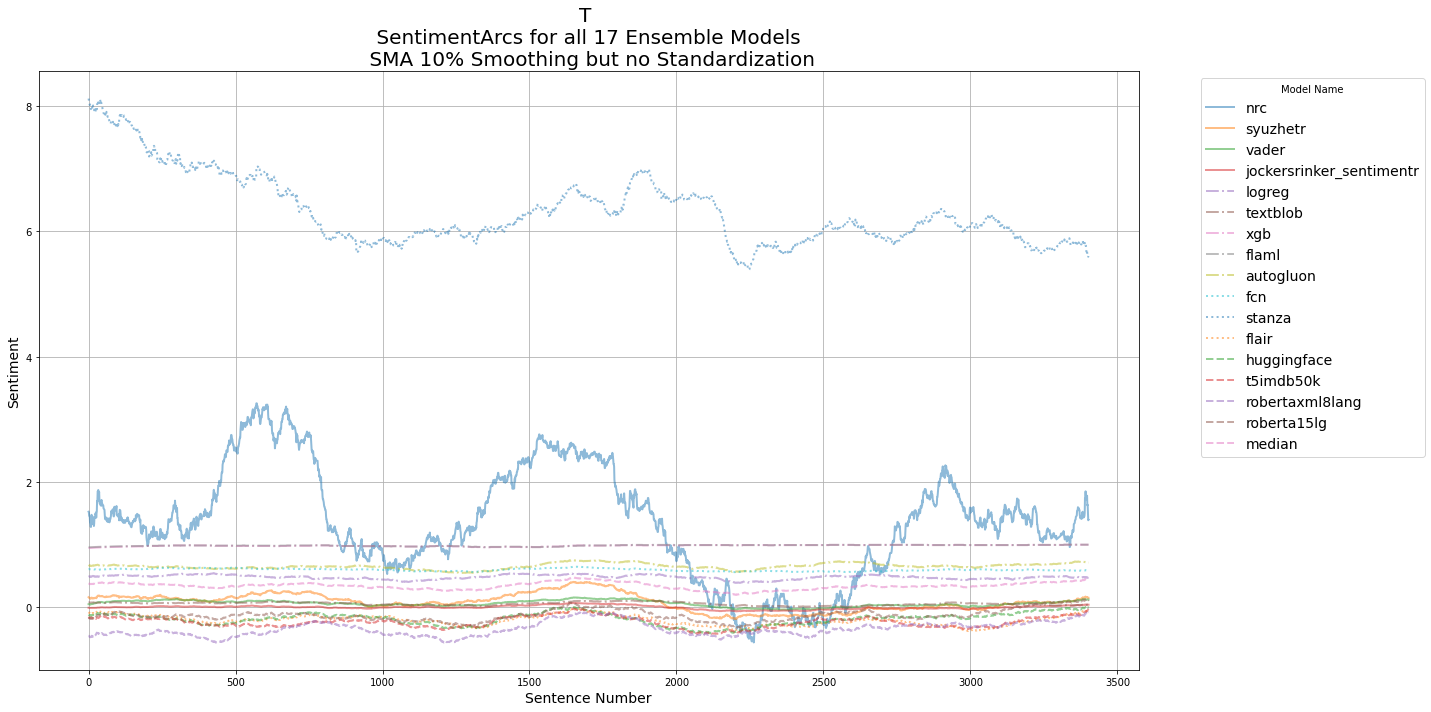

In [76]:
#@title Enter SMA window size as a Percent of total Corpus Length

Window_Percent = 10 #@param {type:"slider", min:1, max:30, step:1}

win_size = int(Window_Percent/100 * ensemble_df.shape[0])

plt.figure(figsize=(20,10))

# If does not exist, calculate smaing mean (SMA)
if ~subensemble_df.columns.str.contains('_sma').any():
  for acol in models_subensemble_ls:
    acol_sma = f'{acol}_sma'
    subensemble_df[acol_sma] = subensemble_df[acol].rolling(win_size, center=True, min_periods=0).mean()

# Plot the SMA (*_sma columns) SentimentArcs for Ensemble Models
for acol in models_subensemble_ls:
  if acol in models_lexicon_ls:
    alinestyle = 'solid'
  elif acol in models_heuristic_ls:
    alinestyle = 'solid'
  elif acol in models_tradml_ls:
    alinestyle = 'dashdot'
  elif acol in models_dnn_ls:
    alinestyle = 'dotted'
  elif acol in models_transformer_ls:
    alinestyle='dashed'

  acol_sma = f'{acol}_sma'
  subensemble_df[acol_sma].plot(alpha=0.5, label=acol, linewidth=2, linestyle=alinestyle)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for all {len(models_subensemble_ls)} Ensemble Models \n SMA {Window_Percent}% Smoothing but no Standardization', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
# plt.legend(title='Model Name', loc='best')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name', fontsize=14)
plt.tight_layout()
plt.show();

In [77]:
ensemble_df.columns

Index(['sent_no', 'parag_no', 'sect_no', 'sent_raw', 'sentimentr', 'syuzhetr',
       'bing', 'sentiword_sentimentr', 'senticnet_sentimentr', 'nrc', 'afinn',
       'vader', 'textblob', 'pattern', 'stanza', 'flair',
       'jockersrinker_sentimentr', 'jockers_sentimentr', 'bing_sentimentr',
       'lmcd_sentimentr', 'roberta15lg', 'yelp', 'nlptown', 'huggingface',
       'hinglish', 'imdb2way', 't5imdb50k', 'robertaxml8lang', 'fcn', 'lstm',
       'cnn', 'sent_clean', 'multinb', 'logreg', 'logreg_cv', 'rf', 'xgb',
       'flaml', 'autogluon', 'huggingface_z', 'pattern_z', 't5imdb50k_z',
       'rf_z', 'robertaxml8lang_z', 'flaml_z', 'jockers_z', 'vader_z', 'cnn_z',
       'lmcd_z', 'stanza_z', 'jockers_rinker_z', 'textblob_z', 'imdb2way_z',
       'senticnet_z', 'logreg_z', 'huliu_z', 'hinglish_z', 'fcn_z',
       'logreg_cv_z', 'lstm_z', 'roberta15lg_z', 'nrc_z', 'afinn_z', 'flair_z',
       'bing_z', 'xgb_z', 'syuzhet_z', 'sentimentr_z', 'nlptown_z', 'yelp_z',
       'sentiword_z', '

# Standardize the SMA Smoothed SentimentArcs

In [78]:
# Select Standardized Method and Standardize all Model Values

#@title Select a Standardization Method to Use:

Model_Standardization_Method = "zScore" #@param ["zScore", "MinMax", "Robust"]

# Create Standardized versions of each Model/Column values
# CAUTION: Only run once

# Select a Standardization method = ['zscore','minmax','robust']
# Model_Standardization_Method = 'robust'

if Model_Standardization_Method == 'zScore':
  scaler = StandardScaler()
elif Model_Standardization_Method == 'MinMax':
  scaler = MinMaxScaler()
elif Model_Standardization_Method == 'Robust':
  scaler = RobustScaler()

# If does not exist, standardize the smaing mean (SMA)
if ~subensemble_df.columns.str.contains('_stdsma').any():
  for acol in models_subensemble_ls:
    acol_sma = f'{acol}_sma'
    acol_stdsma = f'{acol}_stdsma'
    subensemble_df[acol_stdsma] = scaler.fit_transform(subensemble_df[acol_sma].values.reshape(-1,1))

subensemble_df.head()

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhetr,bing,sentiword_sentimentr,senticnet_sentimentr,nrc,afinn,vader,textblob,pattern,stanza,flair,jockersrinker_sentimentr,jockers_sentimentr,bing_sentimentr,lmcd_sentimentr,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,median,nrc_sma,syuzhetr_sma,vader_sma,jockersrinker_sentimentr_sma,logreg_sma,textblob_sma,xgb_sma,flaml_sma,autogluon_sma,fcn_sma,stanza_sma,flair_sma,huggingface_sma,t5imdb50k_sma,robertaxml8lang_sma,roberta15lg_sma,median_sma,nrc_stdsma,syuzhetr_stdsma,vader_stdsma,jockersrinker_sentimentr_stdsma,logreg_stdsma,textblob_stdsma,xgb_stdsma,flaml_stdsma,autogluon_stdsma,fcn_stdsma,stanza_stdsma,flair_stdsma,huggingface_stdsma,t5imdb50k_stdsma,robertaxml8lang_stdsma,roberta15lg_stdsma,median_stdsma
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said ...",1.05,1.05,29.429983,0.250000,-0.702,0.000000,1.201011,0.5423,0.416667,0.173042,4.804044,0.9820,0.316587,0.316587,0.301511,0.0,0.997045,4.530780,2.391533,0.998531,-0.494797,0.785985,1,1.626460,0.799107,0.846307,0.332184,yes of course if it is fine tomorrow said...,1,1,1,1,1,1,1,0.999266,1.525857,0.162059,0.050906,-0.006031,0.488235,0.083371,0.947059,0.958824,0.676471,0.608380,8.119097,-0.077255,-0.116946,-0.170588,-0.454966,-0.166241,0.383928,0.208341,0.566153,-0.219206,-0.230685,0.177745,1.051371,-3.281223,-2.624740,0.456600,0.455218,3.228045,1.599421,0.702436,0.781575,-0.988365,-0.456533,0.762090
1,1,0,0,"""But you'll have to be up with the lark,"" she ...",0.00,0.00,0.000000,-0.343750,0.713,0.000000,0.000000,0.0000,0.000000,0.000000,4.642334,0.9052,0.000000,0.000000,0.000000,0.0,0.861890,2.399060,2.440373,-0.974143,0.846856,-0.537423,-1,0.680818,0.771381,0.850767,0.420182,but you will have to be up with the lark sh...,0,0,0,1,1,1,1,0.340409,1.516934,0.156433,0.050608,-0.007555,0.491228,0.082883,0.947368,0.959064,0.672515,0.609656,8.094528,-0.082622,-0.122038,-0.163743,-0.454941,-0.171114,0.381683,0.197980,0.525335,-0.225460,-0.282843,0.265152,1.031798,-3.254304,-2.601903,0.369317,0.518628,3.183942,1.532853,0.649905,0.861734,-0.988138,-0.510052,0.721381
2,2,1,0,To her son these words conveyed an extraordina...,2.70,1.70,40.884576,-0.229167,3.015,7.198481,0.501025,0.4215,0.583333,0.328472,13.026639,0.9996,0.385714,0.242857,0.285714,0.0,0.998681,4.715061,4.658196,0.999797,1.959686,0.998975,1,1.556802,0.590935,0.995762,0.371851,to her son these words conveyed an extraordina...,1,1,0,1,1,1,1,1.000000,1.459445,0.151163,0.048094,-0.009160,0.494186,0.079494,0.947674,0.959302,0.668605,0.608786,8.064517,-0.087949,-0.127116,-0.168605,-0.463184,-0.175905,0.376900,0.131226,0.487101,-0.278275,-0.337738,0.351541,0.895746,-3.227698,-2.579332,0.283048,0.475400,3.130072,1.466771,0.597515,0.804802,-1.061740,-0.562678,0.634669
3,3,1,0,"Since he belonged, even at the age of six, to ...",4.40,4.40,53.522015,0.281250,2.486,13.693781,2.125322,0.9631,0.011111,0.014445,22.103345,0.9998,0.465000,0.465000,0.300000,0.1,0.996760,4.855800,4.526761,0.998104,0.752392,0.999034,1,-1.373809,0.474658,0.994165,0.015341,since he belonged even at the age of six to ...,1,1,1,1,1,1,1,0.999900,1.451009,0.150289,0.047816,-0.009107,0.491329,0.079035,0.947977,0.959538,0.670520,0.608520,8.043929,-0.084084,-0.123259,-0.161850,-0.463354,-0.169124,0.377909,0.121430,0.480762,-0.284115,-0.335926,0.268113,0.877299,-3.201399,-2.557021,0.325313,0.462169,3.093117,1.514717,0.637304,0.883900,-1.063259,-0.488202,0.652961
4,4,1,0,It was fringed with joy.,0.75,0.75,38.322429,0.125000,0.889,8.613681,1.754963,0.5859,0.800000,0.328472,3.509926,0.9945,0.335410,0.335410,0.447214,0.0,0.998756,3.411104,4.534395,0.999693,1.967229,0.998880,1,1.879106,0.807452,0.660350,0.277155,it was fringed with joy,1,1,1,1,1,1,1,0.999846,1.442670,0.149425,0.047541,-0.009054,0.488506,0.078580,0.948276,0.959770,0.666667,0.608570,8.015928,-0.088587,-0.126016,-0.166667,-0.469480,-0.173896,

## Compare Raw, SMA, SMA+Standardization

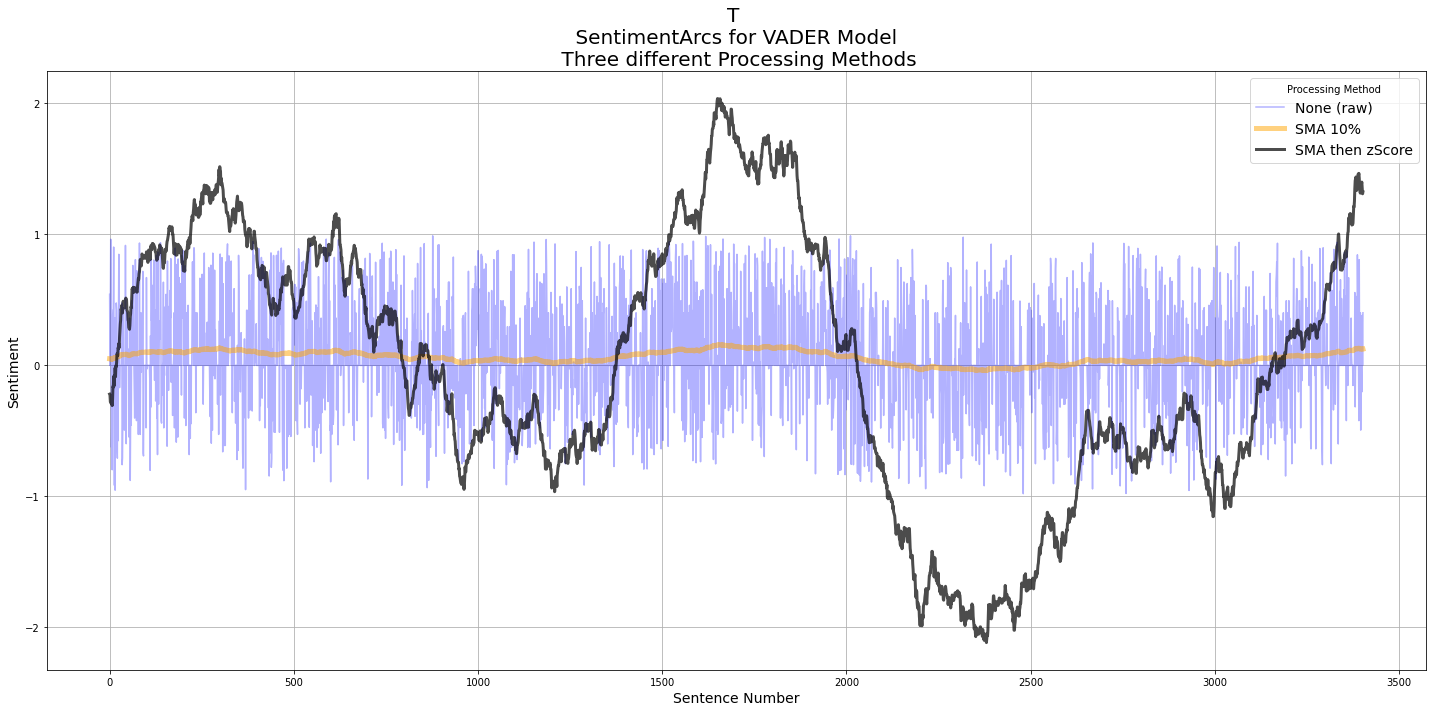

In [79]:
# Compare all three plots for a given Model

model_str = 'vader'

plt.figure(figsize=(20,10))

subensemble_df[model_str].plot(label='None (raw)', color='blue', alpha=0.3)
subensemble_df[f'{model_str}_sma'].plot(label=f'SMA {Window_Percent}%', color='orange', alpha=0.5, linewidth=5)
subensemble_df[f'{model_str}_stdsma'].plot(label=f'SMA then {Model_Standardization_Method}', color='black', alpha=0.7, linewidth=3)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {model_str.upper()} Model \n Three different Processing Methods', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend(title='Processing Method', loc='best', fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()
plt.show();

## Compare Three Standardization Methods

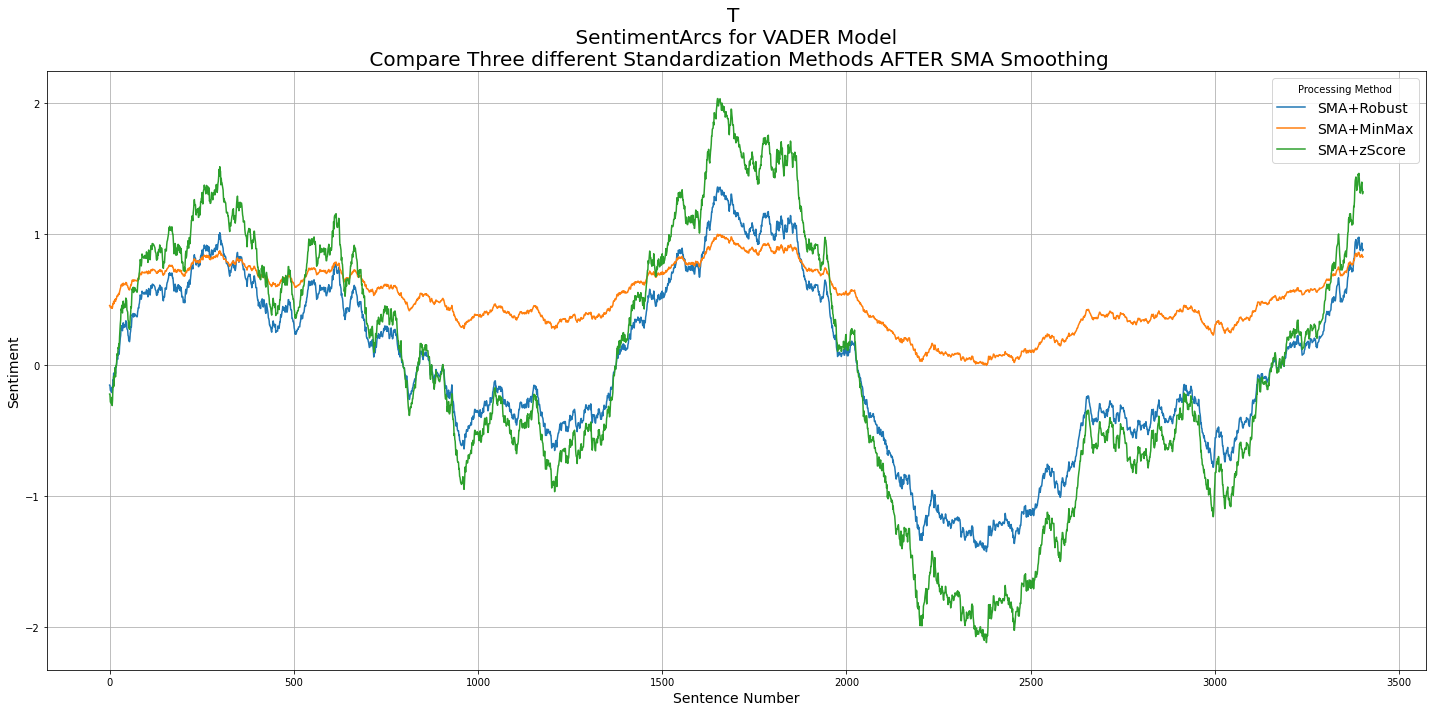

In [80]:
# Compare 3 Standardization Methods with (a)Standardization then (b)SMA Smoothing

model_str = 'vader'

win_per = 10
win_size = int(win_per/100 * ensemble_df.shape[0])

plot_stdsma_fl = False
plot_smastd_fl = True

temp_df = pd.DataFrame()
temp_df['model'] = subensemble_df[model_str].copy(deep=True)
temp_df['model_sma'] = temp_df['model'].rolling(win_size, center=True, min_periods=0).mean()

rscaler = RobustScaler()
temp_df['robust'] = rscaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_robust'] = rscaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


mmscaler = MinMaxScaler()
temp_df['minmax'] = mmscaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_minmax'] = mmscaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


scaler = StandardScaler()
temp_df['zscore'] = scaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_zscore'] = scaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


if plot_smastd_fl:
  temp_df['sma_robust'].plot(label='SMA+Robust')
  temp_df['sma_minmax'].plot(label='SMA+MinMax')
  temp_df['sma_zscore'].plot(label='SMA+zScore')

if plot_stdsma_fl:
  temp_df['robust'].rolling(win_size, center=True, min_periods=0).mean().plot(label='Robust+SMA', color='orange', linewidth=5, alpha=0.3)
  temp_df['minmax'].rolling(win_size, center=True, min_periods=0).mean().plot(label='MinMax+SMA', color='blue', linewidth=5, alpha=0.3)
  temp_df['zscore'].rolling(win_size, center=True, min_periods=0).mean().plot(label='zScore+SMA', color='black', linewidth=5, alpha=0.3)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {model_str.upper()} Model \n Compare Three different Standardization Methods AFTER SMA Smoothing', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend(title='Processing Method', loc='best', fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()
plt.show();

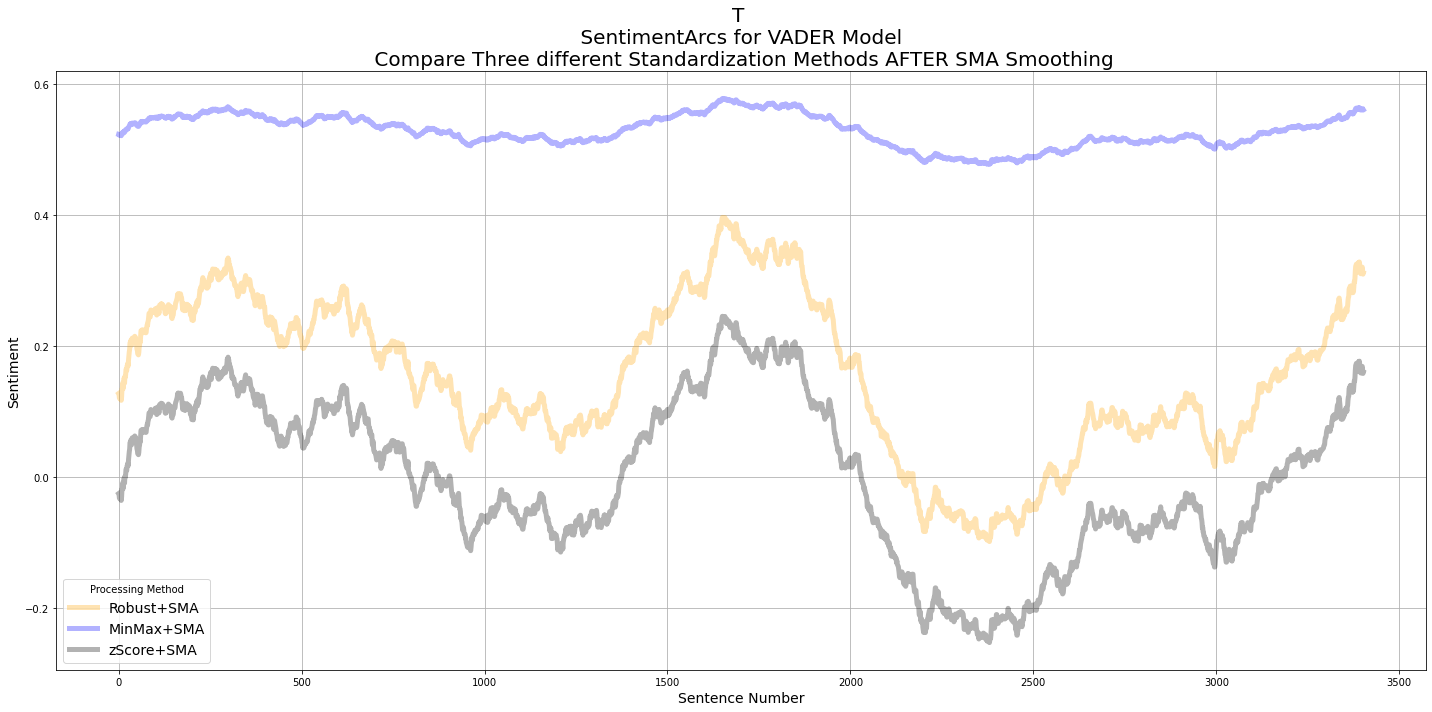

In [81]:
# Compare 3 Standardization Methods with (a)SMA Smoothing then (b)Standardization

model_str = 'vader'

win_per = 10
win_size = int(win_per/100 * ensemble_df.shape[0])

plot_stdsma_fl = True
plot_smastd_fl = False

temp_df = pd.DataFrame()
temp_df['model'] = subensemble_df[model_str].copy(deep=True)
temp_df['model_sma'] = temp_df['model'].rolling(win_size, center=True, min_periods=0).mean()

rscaler = RobustScaler()
temp_df['robust'] = rscaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_robust'] = rscaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


mmscaler = MinMaxScaler()
temp_df['minmax'] = mmscaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_minmax'] = mmscaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


scaler = StandardScaler()
temp_df['zscore'] = scaler.fit_transform(temp_df['model'].values.reshape(-1,1)).flatten()
temp_df['sma_zscore'] = scaler.fit_transform(temp_df['model_sma'].values.reshape(-1,1)).flatten()


if plot_smastd_fl:
  temp_df['sma_robust'].plot(label='SMA+Robust')
  temp_df['sma_minmax'].plot(label='SMA+MinMax')
  temp_df['sma_zscore'].plot(label='SMA+zScore')

if plot_stdsma_fl:
  temp_df['robust'].rolling(win_size, center=True, min_periods=0).mean().plot(label='Robust+SMA', color='orange', linewidth=5, alpha=0.3)
  temp_df['minmax'].rolling(win_size, center=True, min_periods=0).mean().plot(label='MinMax+SMA', color='blue', linewidth=5, alpha=0.3)
  temp_df['zscore'].rolling(win_size, center=True, min_periods=0).mean().plot(label='zScore+SMA', color='black', linewidth=5, alpha=0.3)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {model_str.upper()} Model \n Compare Three different Standardization Methods AFTER SMA Smoothing', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend(title='Processing Method', loc='best', fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()
plt.show();

# Save Checkpoint

In [82]:
!pwd

print('\n')

!ls

/gdrive/My Drive/research/2021/sentiment_arcs


crux				sentiment_arcs
data				sentiment_arcs_cruxes
nlp_sa_dl_novels_20211126.gdoc	sentiment_arcs_dataset
nlp_sa_dl_novels.gdoc		sentiment_arcs_emotions
novels				sentiment_arcs_features
plots				sentiment_arcs_segmentation
sa_time_series_20210912.gdoc


In [83]:
??get_fullpath

In [84]:
# Save newly cleaned (Smoothed then Standardized) Ensemble Model data

# file_fullpath = get_fullpath(ftype='data_clean', novel_title=Novel_Title, std_method=Model_Standardization_Method, win_per = Window_Percent, no_date=False)

file_fullpath = get_fullpath(ftype='data_clean')
ensemble_df.to_csv(file_fullpath)

print(f'Saved to file: {file_fullpath}')

# Temp Fix:
file_fullpath = file_fullpath.split('[')[-1][:-1]
file_fullpath

subensemble_df.to_csv(file_fullpath)

print(f'Saved to file: {file_fullpath}')

Saved to file: ./data/sentiments_clean/sa_clean_t_zscore_sma10_2021_11_28-10_56_37_PM.csv


'./data/sentiments_clean/sa_clean_t_zscore_sma10_2021_11_28-10_56_37_PM.cs'

Saved to file: ./data/sentiments_clean/sa_clean_t_zscore_sma10_2021_11_28-10_56_37_PM.cs


In [86]:
# Verify saved file contents

!head -n 10 $file_fullpath

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhetr,bing,sentiword_sentimentr,senticnet_sentimentr,nrc,afinn,vader,textblob,pattern,stanza,flair,jockersrinker_sentimentr,jockers_sentimentr,bing_sentimentr,lmcd_sentimentr,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,median,nrc_sma,syuzhetr_sma,vader_sma,jockersrinker_sentimentr_sma,logreg_sma,textblob_sma,xgb_sma,flaml_sma,autogluon_sma,fcn_sma,stanza_sma,flair_sma,huggingface_sma,t5imdb50k_sma,robertaxml8lang_sma,roberta15lg_sma,median_sma,nrc_stdsma,syuzhetr_stdsma,vader_stdsma,jockersrinker_sentimentr_stdsma,logreg_stdsma,textblob_stdsma,xgb_stdsma,flaml_stdsma,autogluon_stdsma,fcn_stdsma,stanza_stdsma,flair_stdsma,huggingface_stdsma,t5imdb50k_stdsma,robertaxml8lang_stdsma,roberta15lg_stdsma,median_stdsma
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said Mrs. Ramsay.",1.05,1.05,29.429982966380248,0.25,-0.7019999999999

# **Plot Sentiment Arcs**

In [88]:
# Confirm Ensemble Models and Optionally Save Plot to File

#@title Confirm Ensemble SentimentArcs and Option to Saved:
Save_Plot = True #@param {type:"boolean"}
HiRes_300dpi = True #@param {type:"boolean"}

# ensemble_ls = ensemble_lexicon_ls + ensemble_heuristic_ls + ensemble_tradml_ls + \
#               ensemble_dnn_ls + ensemble_transformer_ls

print(f'Confirm these are the all the Model(s) to include in the Ensemble:\n')

for i, amodel in enumerate(cols_ensemble_ls):
  print(f'  Model #{i:>2}: {amodel}') # ({models_dt[amodel][1]})')

print(f'\nIf there is an error in these {len(cols_ensemble_ls)} models, \n go back and rerun the previous code cells.')

Confirm these are the all the Model(s) to include in the Ensemble:

  Model # 0: nrc
  Model # 1: syuzhetr
  Model # 2: vader
  Model # 3: jockersrinker_sentimentr
  Model # 4: logreg
  Model # 5: textblob
  Model # 6: xgb
  Model # 7: flaml
  Model # 8: autogluon
  Model # 9: fcn
  Model #10: stanza
  Model #11: flair
  Model #12: huggingface
  Model #13: t5imdb50k
  Model #14: robertaxml8lang
  Model #15: roberta15lg

If there is an error in these 16 models, 
 go back and rerun the previous code cells.


## Detailed SMA Plots

In [94]:
Novel_Title

'To The Lighthouse by Virginia Woolf'

Saved hi-res 300dpi Plot to: ./plots/plot_t_17models_sma10_300dpi.png


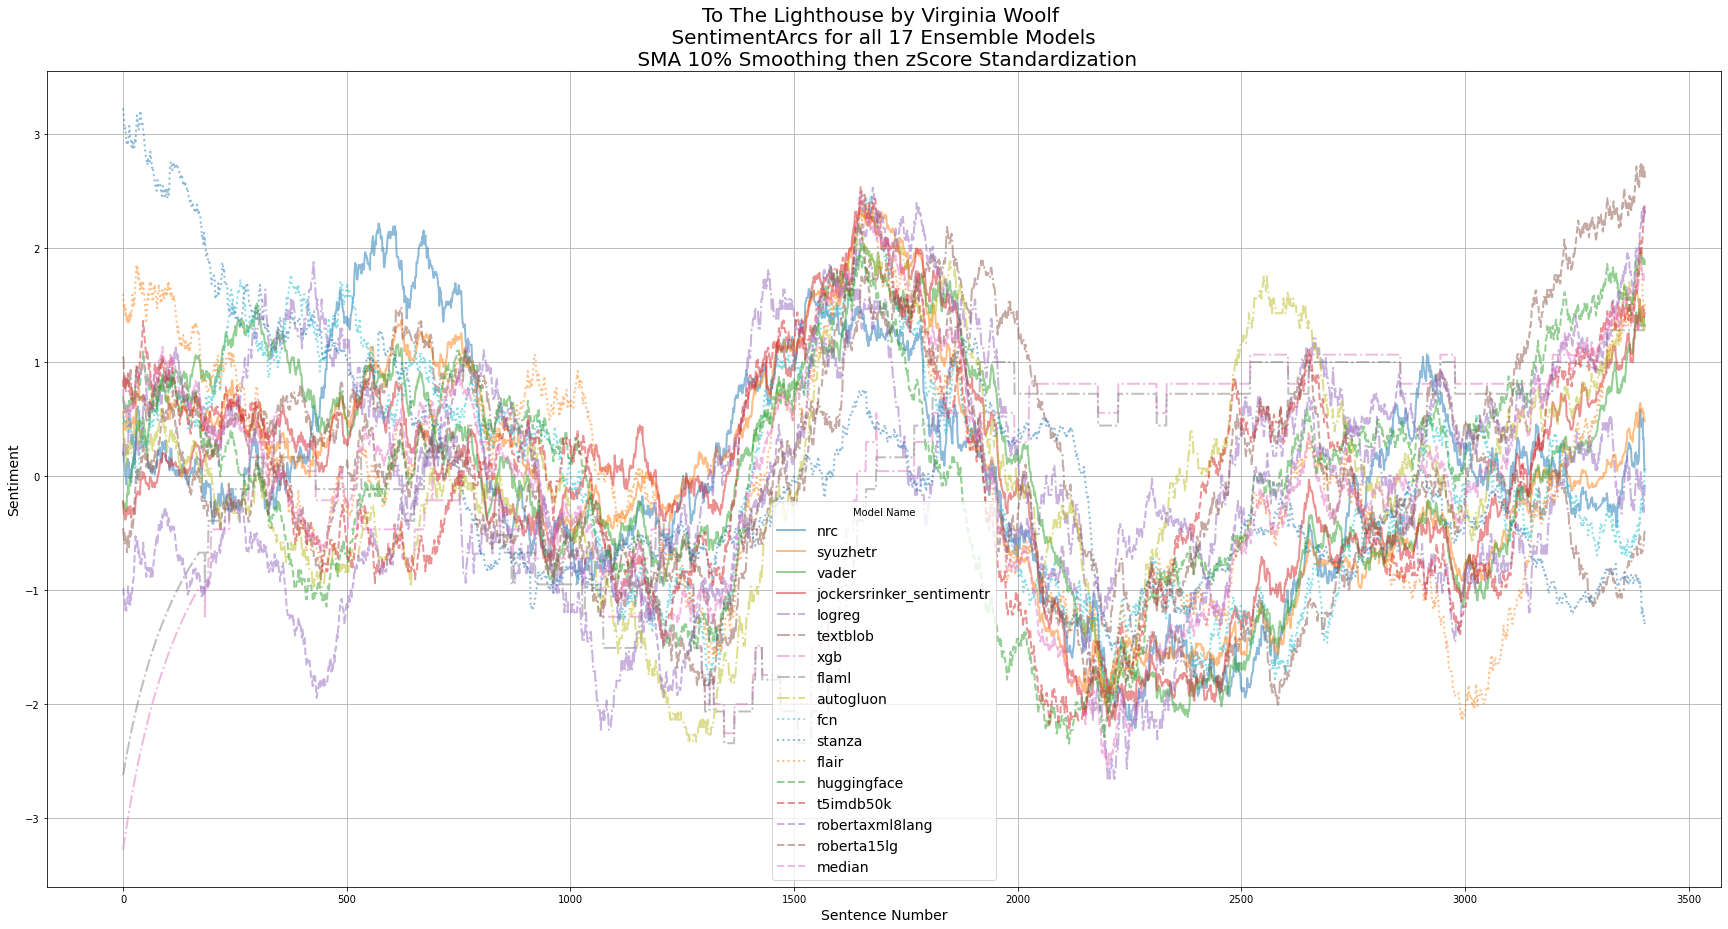

In [95]:
# Plot all the Model values that have been Smoothed then Standardized

plt.figure(figsize=(30,15))

# cols_stdsma_ls = [x for x in ensemble_df.columns if x.endswith('_stdsma')]

# cols_sma_ls = [x for x in ensemble_df.columns if x.endswith('_sma')]
for acol in models_subensemble_ls:
  if acol in models_lexicon_ls:
    alinestyle = 'solid'
  elif acol in models_heuristic_ls:
    alinestyle = 'solid'
  elif acol in models_tradml_ls:
    alinestyle = 'dashdot'
  elif acol in models_dnn_ls:
    alinestyle = 'dotted'
  elif acol in models_transformer_ls:
    alinestyle='dashed'

  acol_stdsma = f'{acol}_stdsma'
  subensemble_df[acol_stdsma].plot(alpha=0.5, label=acol, linewidth=2, linestyle=alinestyle)

plt.grid(True)
# plt.title(f'{Novel_Title[0]} \n Sentiment Analysis \n SMA {Window_Percent}% Smoothing then {Model_Standardization_Method} Standardization', fontsize=20)
plt.title(f'{Novel_Title} \n SentimentArcs for all {len(models_subensemble_ls)} Ensemble Models \n SMA {Window_Percent}% Smoothing then {Model_Standardization_Method} Standardization', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)

plt.legend(title='Model Name', loc='best', fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name', prop={"size":16})
# plt.tight_layout()

if Save_Plot:
  # get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)
  if HiRes_300dpi:
    #fig.set_size_inches(30.,18.)
    # figsize_tup = (40,20)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'{len(models_subensemble_ls)}models', last_note=f'sma{Window_Percent}_300dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=300)
    print(f'Saved hi-res 300dpi Plot to: {plot_fullpath}')
  else:
    # figsize_tup = (20,10)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'{len(models_subensemble_ls)}models', last_note=f'sma{Window_Percent}_100dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=100)
    print(f'Saved low-res 100dpi Plot to: {plot_fullpath}')

plt.show();


## General LOWESS Plots

In [93]:
def get_lowess_sma(adf, acol, awin_per=10, afrac=0.08):
  '''
  Given a DataFrame, Column Name and Frac float
  Return an (n x 2)np.array of LOWESS x,y smoothed values and SMA y_sma values
  '''

  # win_per = 10 # SMA window as % of corpus length
  win_size = int(awin_per/100*adf.shape[0])
  
  # Generate data looking like cosine
  x = adf.index # np.random.uniform(0, 4 * np.pi, size=200)
  # Experiment: apply LOWESS smoothing after SMA smoothing
  y_sma = adf[acol].rolling(win_size, center=True, min_periods=0).mean().values # np.cos(x) + np.random.random(size=len(x))
  y = adf[acol]

  # Compute a lowess smoothing of the data
  smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=afrac)

  return x, y, y_sma, smoothed

<Figure size 2160x1080 with 0 Axes>

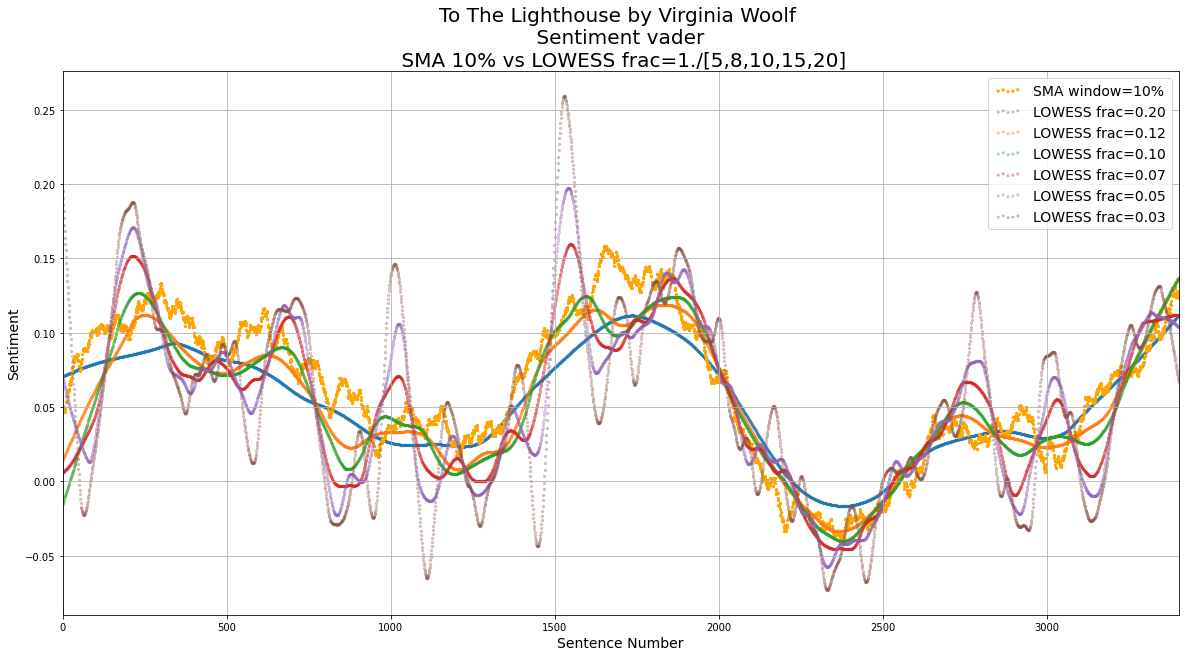

In [100]:
# Compare SMA vs LOWESS both working on raw time series
# NOTE: Big disagreement 

afrac_ls = [1./8, 1./10, 1./15, 1./20]
awin_per = 10

amodel = 'vader'
# amodel = 'vader_stdsma'
# x, y, y_sma, smoothed = get_lowess_sma(ensemble_df, amodel, awin_per=awin_per, afrac=afrac)

plt.figure(figsize=(30,15))

# Plot the fit line
fig, ax = plt.subplots()

# raw_arc = ax.scatter(x, y, color='blue', alpha=0.1)
# sma_arc = ax.scatter(x, y_sma, s=5, color='orange')

x, y, y_sma, smoothed5 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./5)
lowess_arc5 = ax.scatter(smoothed5[:, 0], smoothed5[:, 1], s=5, alpha=0.3) # c="grey", s=5)
sma_arc = ax.scatter(x, y_sma, s=5, color='orange')

_, _, _, smoothed8 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./8)
lowess_arc8 = ax.scatter(smoothed8[:, 0], smoothed8[:, 1], s=5, alpha=0.3) # , c="navy", s=5)

_, _, _, smoothed10 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./10)
lowess_arc10 = ax.scatter(smoothed10[:, 0], smoothed10[:, 1], s=5, alpha=0.3) # , c="navy", s=5)

_, _, _, smoothed15 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./15)
lowess_arc15 = ax.scatter(smoothed15[:, 0], smoothed15[:, 1], s=5, alpha=0.3) # , c="navy", s=5)

_, _, _, smoothed20 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./20)
lowess_arc20 = ax.scatter(smoothed20[:, 0], smoothed20[:, 1], s=5, alpha=0.3) # , c="black", s=5)

_, _, _, smoothed30 = get_lowess_sma(subensemble_df, amodel, awin_per=awin_per, afrac=1./30)
lowess_arc30 = ax.scatter(smoothed30[:, 0], smoothed30[:, 1], s=5, alpha=0.3) # , c="black", s=5)


ax.set_title(f"{Novel_Title} \n Sentiment {amodel.split('_')[0]} \n SMA {awin_per}% vs LOWESS frac=1./[5,8,10,15,20]", fontsize=20)
ax.set_xlabel('Sentence Number', fontsize=14)
ax.set_ylabel('Sentiment', fontsize=14)
plt.legend((sma_arc, lowess_arc5, lowess_arc8, lowess_arc10, lowess_arc15, lowess_arc20, lowess_arc30), # 
           # (raw_arc, sma_arc, lowess_arc),
           (f'SMA window={awin_per}%', f'LOWESS frac={1./5:.2f}', f'LOWESS frac={1./8:.2f}', f'LOWESS frac={1./10:.2f}', f'LOWESS frac={1./15:.2f}', f'LOWESS frac={1./20:.2f}', f'LOWESS frac={1./30:.2f}'),
           # ('Raw Values', f'SMA window={awin_per}%', f'LOWESS frac={afrac:.3f}'),
           scatterpoints=5,
           loc='best',
           # ncol=3,
           fontsize=14)
plt.autoscale(enable=True, axis="x", tight=True)
plt.grid()
plt.show();

In [101]:
subensemble_df.head()

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhetr,bing,sentiword_sentimentr,senticnet_sentimentr,nrc,afinn,vader,textblob,pattern,stanza,flair,jockersrinker_sentimentr,jockers_sentimentr,bing_sentimentr,lmcd_sentimentr,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,median,nrc_sma,syuzhetr_sma,vader_sma,jockersrinker_sentimentr_sma,logreg_sma,textblob_sma,xgb_sma,flaml_sma,autogluon_sma,fcn_sma,stanza_sma,flair_sma,huggingface_sma,t5imdb50k_sma,robertaxml8lang_sma,roberta15lg_sma,median_sma,nrc_stdsma,syuzhetr_stdsma,vader_stdsma,jockersrinker_sentimentr_stdsma,logreg_stdsma,textblob_stdsma,xgb_stdsma,flaml_stdsma,autogluon_stdsma,fcn_stdsma,stanza_stdsma,flair_stdsma,huggingface_stdsma,t5imdb50k_stdsma,robertaxml8lang_stdsma,roberta15lg_stdsma,median_stdsma
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said ...",1.05,1.05,29.429983,0.250000,-0.702,0.000000,1.201011,0.5423,0.416667,0.173042,4.804044,0.9820,0.316587,0.316587,0.301511,0.0,0.997045,4.530780,2.391533,0.998531,-0.494797,0.785985,1,1.626460,0.799107,0.846307,0.332184,yes of course if it is fine tomorrow said...,1,1,1,1,1,1,1,0.999266,1.525857,0.162059,0.050906,-0.006031,0.488235,0.083371,0.947059,0.958824,0.676471,0.608380,8.119097,-0.077255,-0.116946,-0.170588,-0.454966,-0.166241,0.383928,0.208341,0.566153,-0.219206,-0.230685,0.177745,1.051371,-3.281223,-2.624740,0.456600,0.455218,3.228045,1.599421,0.702436,0.781575,-0.988365,-0.456533,0.762090
1,1,0,0,"""But you'll have to be up with the lark,"" she ...",0.00,0.00,0.000000,-0.343750,0.713,0.000000,0.000000,0.0000,0.000000,0.000000,4.642334,0.9052,0.000000,0.000000,0.000000,0.0,0.861890,2.399060,2.440373,-0.974143,0.846856,-0.537423,-1,0.680818,0.771381,0.850767,0.420182,but you will have to be up with the lark sh...,0,0,0,1,1,1,1,0.340409,1.516934,0.156433,0.050608,-0.007555,0.491228,0.082883,0.947368,0.959064,0.672515,0.609656,8.094528,-0.082622,-0.122038,-0.163743,-0.454941,-0.171114,0.381683,0.197980,0.525335,-0.225460,-0.282843,0.265152,1.031798,-3.254304,-2.601903,0.369317,0.518628,3.183942,1.532853,0.649905,0.861734,-0.988138,-0.510052,0.721381
2,2,1,0,To her son these words conveyed an extraordina...,2.70,1.70,40.884576,-0.229167,3.015,7.198481,0.501025,0.4215,0.583333,0.328472,13.026639,0.9996,0.385714,0.242857,0.285714,0.0,0.998681,4.715061,4.658196,0.999797,1.959686,0.998975,1,1.556802,0.590935,0.995762,0.371851,to her son these words conveyed an extraordina...,1,1,0,1,1,1,1,1.000000,1.459445,0.151163,0.048094,-0.009160,0.494186,0.079494,0.947674,0.959302,0.668605,0.608786,8.064517,-0.087949,-0.127116,-0.168605,-0.463184,-0.175905,0.376900,0.131226,0.487101,-0.278275,-0.337738,0.351541,0.895746,-3.227698,-2.579332,0.283048,0.475400,3.130072,1.466771,0.597515,0.804802,-1.061740,-0.562678,0.634669
3,3,1,0,"Since he belonged, even at the age of six, to ...",4.40,4.40,53.522015,0.281250,2.486,13.693781,2.125322,0.9631,0.011111,0.014445,22.103345,0.9998,0.465000,0.465000,0.300000,0.1,0.996760,4.855800,4.526761,0.998104,0.752392,0.999034,1,-1.373809,0.474658,0.994165,0.015341,since he belonged even at the age of six to ...,1,1,1,1,1,1,1,0.999900,1.451009,0.150289,0.047816,-0.009107,0.491329,0.079035,0.947977,0.959538,0.670520,0.608520,8.043929,-0.084084,-0.123259,-0.161850,-0.463354,-0.169124,0.377909,0.121430,0.480762,-0.284115,-0.335926,0.268113,0.877299,-3.201399,-2.557021,0.325313,0.462169,3.093117,1.514717,0.637304,0.883900,-1.063259,-0.488202,0.652961
4,4,1,0,It was fringed with joy.,0.75,0.75,38.322429,0.125000,0.889,8.613681,1.754963,0.5859,0.800000,0.328472,3.509926,0.9945,0.335410,0.335410,0.447214,0.0,0.998756,3.411104,4.534395,0.999693,1.967229,0.998880,1,1.879106,0.807452,0.660350,0.277155,it was fringed with joy,1,1,1,1,1,1,1,0.999846,1.442670,0.149425,0.047541,-0.009054,0.488506,0.078580,0.948276,0.959770,0.666667,0.608570,8.015928,-0.088587,-0.126016,-0.166667,-0.469480,-0.173896,

In [ ]:
# Compare all three plots (raw, SMA, SMA+zScore) for a given Model
"""
model_str = 'vader'

ensemble_df[model_str].plot(label='raw', alpha=0.3)
ensemble_df[f'{model_str}_sma'].plot(label=f'SMA {Window_Percent}%', alpha=0.5, linewidth=5)
ensemble_df[f'{model_str}_stdsma'].plot(label=f'SMA then Std {Model_Standardization_Method}', alpha=0.7, linewidth=3)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {model_str.upper()} Model \n (a)Raw, (b)SMA ({Window_Percent}%) and (c)SMA then Standardize ({Model_Standardization_Method})', fontsize=20)
plt.xlabel('Sentence Number')
plt.ylabel('Sentiment')
plt.legend(title='Processing Method', loc='best')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()
""";

Plotting Model: VADER
Saved hi-res 300dpi Plot to: ./plots/plot_t_sma10_vs_lowess30_300dpi.png


<Figure size 2160x1080 with 0 Axes>

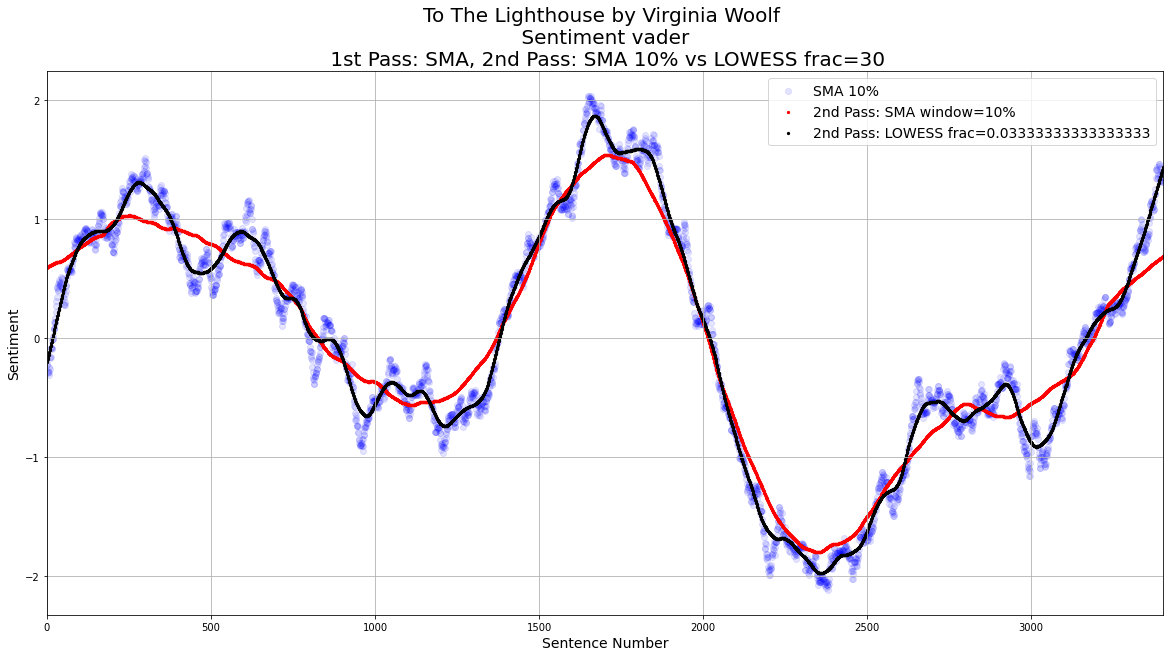

In [104]:
# Compare LOWESS smoothed version of SMA Smoothed Standardized Model

#@title Compare SMA and LOWESS smoothed values of Model

# Standardized Model Values
Standardized_Model = "VADER" #@param ["VADER", "TextBlob", "RoBERTa"]

# Simple Moving Average Smoothing Window Size
Window_Percent = 10 #@param {type:"slider", min:1, max:30, step:1}

# LOWESS Smoothing Fraction Size
LOWESS_Fraction = 30 #@param {type:"slider", min:1, max:30, step:1}
# Confirm Ensemble Models and Optionally Save Plot to File

#@markdown Confirm Ensemble SentimentArcs and Option to Saved:
Save_Plot = True #@param {type:"boolean"}
HiRes_300dpi = True #@param {type:"boolean"}

# ensemble_ls = ensemble_lexicon_ls + ensemble_heuristic_ls + ensemble_tradml_ls + \
#               ensemble_dnn_ls + ensemble_transformer_ls

# print(f'Confirm these are the all the Model(s) to include in the Ensemble:\n')

# for i, amodel in enumerate(ensemble_ls):
#   print(f'  Model #{i:>2}: {amodel} ({models_dt[amodel][1]})')

# print(f'\nIf there is an error in these {len(ensemble_ls)} models, \n go back and rerun the previous code cells.')

# KEY DECISION: (LOWESS of SMA+STD) > (LOWESS of RAW+STD)
col_model = f'{Standardized_Model.lower()}_stdsma'
# col_model = f'{Standardized_Model.lower()}'

print(f'Plotting Model: {Standardized_Model}') # col_model}')
lowess_frac = 1./LOWESS_Fraction

win_size = int(Window_Percent/100 * ensemble_df.shape[0])

# Get LOWESS values
x, y, y_sma, smoothed = get_lowess_sma(subensemble_df, col_model, awin_per=Window_Percent, afrac=lowess_frac)

plt.figure(figsize=(30,15))

# Plot the fit line
fig, ax = plt.subplots()

raw_arc = ax.scatter(x, y, c='blue', alpha=0.1)
sma_arc = ax.scatter(x, y_sma, c='red', s=5)
lowess_arc = ax.scatter(smoothed[:, 0], smoothed[:, 1], c="black", s=5)
ax.set_title(f"{Novel_Title} \n Sentiment {amodel.split('_')[0]} \n 1st Pass: SMA, 2nd Pass: SMA {Window_Percent}% vs LOWESS frac={LOWESS_Fraction}", fontsize=20)
ax.set_xlabel('Sentence Number', fontsize=14)
ax.set_ylabel('Sentiment', fontsize=14)
plt.legend((raw_arc, sma_arc, lowess_arc),
           ('SMA 10%', f'2nd Pass: SMA window={Window_Percent}%', f'2nd Pass: LOWESS frac={lowess_frac}'),
           scatterpoints=1,
           loc='best',
           # ncol=3,
           fontsize=14)
plt.autoscale(enable=True, axis="x", tight=True)
plt.grid(True)

"""
plt.grid(True)
# plt.title(f'{Novel_Title[0]} \n Sentiment Analysis \n SMA {Window_Percent}% Smoothing then {Model_Standardization_Method} Standardization', fontsize=20)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for all {len(cols_model_ls)} Ensemble Models \n SMA {Window_Percent}% Smoothing then {Model_Standardization_Method} Standardization', fontsize=20)
plt.xlabel('Sentence Number')
plt.ylabel('Sentiment')
# plt.legend(title='Model Name', loc='best')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name', prop={"size":16})
plt.tight_layout()
""";

if Save_Plot:
  # get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)
  if HiRes_300dpi:
    # fig.set_size_inches(30.,18.)
    # figsize_tup = (40,20)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'sma{Window_Percent}_vs_lowess{LOWESS_Fraction}_300dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=300)
    print(f'Saved hi-res 300dpi Plot to: {plot_fullpath}')
  else:
    # figsize_tup = (20,10)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'sma{Window_Percent}_vs_lowess{LOWESS_Fraction}_100dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=100)
    print(f'Saved low-res 100dpi Plot to: {plot_fullpath}')

plt.show();



"""
# Plot the fit line
fig, ax = pylab.subplots()

ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
ax.set_ylabel('Standardized Sentiment/Emotion Value')
ax.set_xlabel('Sentence Number')
ax.set_title(f'{Novel_Title[0]}\n Sentiment/Emotion Model: {Standardized_Model} \n Smoothing: LOWESS (frac=1/{LOWESS_Fraction}) vs SMA ({Window_Percent}%)')
pylab.autoscale(enable=True, axis="x", tight=True)
""";

"""
# Plot the fit line
fig, ax = pylab.subplots()

smoothed_np = get_lowess(novel_df, col_model, win_size, lowess_frac)

y_smaing = novel_df[col_model].smaing(win_size, center=True, min_periods=0).mean().values

ax.scatter(novel_df.index, y_smaing) 
ax.plot(smoothed_np[:, 0], smoothed_np[:, 1], c="k")
pylab.autoscale(enable=True, axis="x", tight=True)
plt.title(f'{Novel_Title}\n Sentiment/Emotion Model: {Standardized_Model} \n Smoothing: LOWESS (frac=1/{LOWESS_Fraction}) vs SMA ({Window_Percent}%)')
""";

# Get LOWESS smoothed values for all Standardized Models



In [105]:
subensemble_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 3402
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sent_no                          3403 non-null   int64  
 1   parag_no                         3403 non-null   int64  
 2   sect_no                          3403 non-null   int64  
 3   sent_raw                         3403 non-null   object 
 4   sentimentr                       3403 non-null   float64
 5   syuzhetr                         3403 non-null   float64
 6   bing                             3403 non-null   float64
 7   sentiword_sentimentr             3403 non-null   float64
 8   senticnet_sentimentr             3403 non-null   float64
 9   nrc                              3403 non-null   float64
 10  afinn                            3403 non-null   float64
 11  vader                            3403 non-null   float64
 12  textblob            

In [106]:
subensemble_df.drop(columns=[x for x in subensemble_df.columns if x.endswith('lowess')], inplace=True)

In [107]:
# Compute LOWESS smoothed and LOWESS smoothed+Standardized time series in ensemble DataFrame

# novel_lowess_dt = {}
model_labels_dt = {}

# If does not exist, calculate LOWESS(*_lowess) and LOWESS+Standardized(*_stdlowess) values/columns
if ~subensemble_df.columns.str.contains('_stdlowess').any():
  for i, amodel in enumerate(cols_ensemble_ls):
    print(f'Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model #{i:>2}: {amodel}')
    lowess_frac = 1./int(LOWESS_Fraction)
    amodel_stdsma = f'{amodel}_stdsma'
    amodel_lowess = f'{amodel}_lowess'
    amodel_stdlowess = f'{amodel}_stdlowess'

    # KEY DECISION: (LOWESS of SMA+STD:amodel_stdsma) > (LOWESS of RAW+STD:amodel)
    # _, _, _, smoothed = get_lowess(subensemble_df, amodel, awin_per=Window_Percent, afrac=lowess_frac)
    _, _, _, smoothed = get_lowess_sma(subensemble_df, amodel_stdsma, awin_per=Window_Percent, afrac=lowess_frac)
    x_vals = smoothed[:, 0]
    y_vals = smoothed[:, 1]
    # novel_lowess_dt[amodel] = (x_vals, y_vals)
    subensemble_df[amodel_lowess] = pd.Series(y_vals)
    subensemble_df[amodel_stdlowess] = scaler.fit_transform(subensemble_df[amodel_lowess].values.reshape(-1,1))

Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 0: nrc
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 1: syuzhetr
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 2: vader
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 3: jockersrinker_sentimentr
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 4: logreg
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 5: textblob
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 6: xgb
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 7: flaml
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 8: autogluon
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model # 9: fcn
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model #10: stanza
Calculating (a)LOWESS and (b)LOWESS+Standardized values for Model #11: flair
Calculating (a)LOWESS and (b)LOWESS+Standardized va

In [108]:
subensemble_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 3402
Data columns (total 106 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   sent_no                             int64  
 1   parag_no                            int64  
 2   sect_no                             int64  
 3   sent_raw                            object 
 4   sentimentr                          float64
 5   syuzhetr                            float64
 6   bing                                float64
 7   sentiword_sentimentr                float64
 8   senticnet_sentimentr                float64
 9   nrc                                 float64
 10  afinn                               float64
 11  vader                               float64
 12  textblob                            float64
 13  pattern                             float64
 14  stanza                              float64
 15  flair                               float64
 16  jocke

In [109]:
subensemble_df.head()

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhetr,bing,sentiword_sentimentr,senticnet_sentimentr,nrc,afinn,vader,textblob,pattern,stanza,flair,jockersrinker_sentimentr,jockers_sentimentr,bing_sentimentr,lmcd_sentimentr,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,median,...,fcn_stdsma,stanza_stdsma,flair_stdsma,huggingface_stdsma,t5imdb50k_stdsma,robertaxml8lang_stdsma,roberta15lg_stdsma,median_stdsma,nrc_lowess,nrc_stdlowess,syuzhetr_lowess,syuzhetr_stdlowess,vader_lowess,vader_stdlowess,jockersrinker_sentimentr_lowess,jockersrinker_sentimentr_stdlowess,logreg_lowess,logreg_stdlowess,textblob_lowess,textblob_stdlowess,xgb_lowess,xgb_stdlowess,flaml_lowess,flaml_stdlowess,autogluon_lowess,autogluon_stdlowess,fcn_lowess,fcn_stdlowess,stanza_lowess,stanza_stdlowess,flair_lowess,flair_stdlowess,huggingface_lowess,huggingface_stdlowess,t5imdb50k_lowess,t5imdb50k_stdlowess,robertaxml8lang_lowess,robertaxml8lang_stdlowess,roberta15lg_lowess,roberta15lg_stdlowess
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said ...",1.05,1.05,29.429983,0.250000,-0.702,0.000000,1.201011,0.5423,0.416667,0.173042,4.804044,0.9820,0.316587,0.316587,0.301511,0.0,0.997045,4.530780,2.391533,0.998531,-0.494797,0.785985,1,1.626460,0.799107,0.846307,0.332184,yes of course if it is fine tomorrow said...,1,1,1,1,1,1,1,0.999266,...,0.455218,3.228045,1.599421,0.702436,0.781575,-0.988365,-0.456533,0.762090,0.119640,0.124415,0.459616,0.466382,-0.201343,-0.204169,-0.352598,-0.357477,0.193096,0.200108,0.793626,0.807361,-3.172235,-3.208408,-2.533316,-2.584309,0.273643,0.277160,0.323044,0.332132,3.094488,3.143072,1.477992,1.518534,0.661182,0.673353,0.785951,0.811431,-1.082813,-1.106597,-0.575137,-0.585992
1,1,0,0,"""But you'll have to be up with the lark,"" she ...",0.00,0.00,0.000000,-0.343750,0.713,0.000000,0.000000,0.0000,0.000000,0.000000,4.642334,0.9052,0.000000,0.000000,0.000000,0.0,0.861890,2.399060,2.440373,-0.974143,0.846856,-0.537423,-1,0.680818,0.771381,0.850767,0.420182,but you will have to be up with the lark sh...,0,0,0,1,1,1,1,0.340409,...,0.518628,3.183942,1.532853,0.649905,0.861734,-0.988138,-0.510052,0.721381,0.121162,0.125963,0.463063,0.469871,-0.188799,-0.191428,-0.347251,-0.352051,0.199711,0.206980,0.791172,0.804858,-3.153813,-3.189788,-2.517666,-2.568356,0.274780,0.278327,0.323756,0.332865,3.089026,3.137520,1.480579,1.521188,0.664149,0.676373,0.788533,0.814082,-1.075955,-1.099585,-0.562346,-0.572838
2,2,1,0,To her son these words conveyed an extraordina...,2.70,1.70,40.884576,-0.229167,3.015,7.198481,0.501025,0.4215,0.583333,0.328472,13.026639,0.9996,0.385714,0.242857,0.285714,0.0,0.998681,4.715061,4.658196,0.999797,1.959686,0.998975,1,1.556802,0.590935,0.995762,0.371851,to her son these words conveyed an extraordina...,1,1,0,1,1,1,1,1.000000,...,0.475400,3.130072,1.466771,0.597515,0.804802,-1.061740,-0.562678,0.634669,0.122663,0.127488,0.466501,0.473351,-0.176285,-0.178717,-0.341908,-0.346629,0.206340,0.213867,0.788752,0.802390,-3.135415,-3.171192,-2.502035,-2.552423,0.275910,0.279486,0.324521,0.333653,3.083551,3.131955,1.483146,1.523823,0.667085,0.679361,0.791107,0.816725,-1.069112,-1.092590,-0.549586,-0.559716
3,3,1,0,"Since he belonged, even at the age of six, to ...",4.40,4.40,53.522015,0.281250,2.486,13.693781,2.125322,0.9631,0.011111,0.014445,22.103345,0.9998,0.465000,0.465000,0.300000,0.1,0.996760,4.855800,4.526761,0.998104,0.752392,0.999034,1,-1.373809,0.474658,0.994165,0.015341,since he belonged even at the age of six to ...,1,1,1,1,1,1,1,0.999900,...,0.462169,3.093117,1.514717,0.637304,0.883900,-1.063259,-0.488202,0.652961,0.124141,0.128990,0.469929,0.476821,-0.163804,-0.166040,-0.336571,-0.341214,0.212982,0.220768,0.786366,0.799956,-3.117038,-3.152618,-2.486423,-2.536510,0.277034,0.280639,0.325340,0.334497,3.078062,3.126377,1.485692,1.526436,0.669990,0.682317,0.793672,0.819359,-1.062285,-1.085610,-0.536859,-0.546626
4,

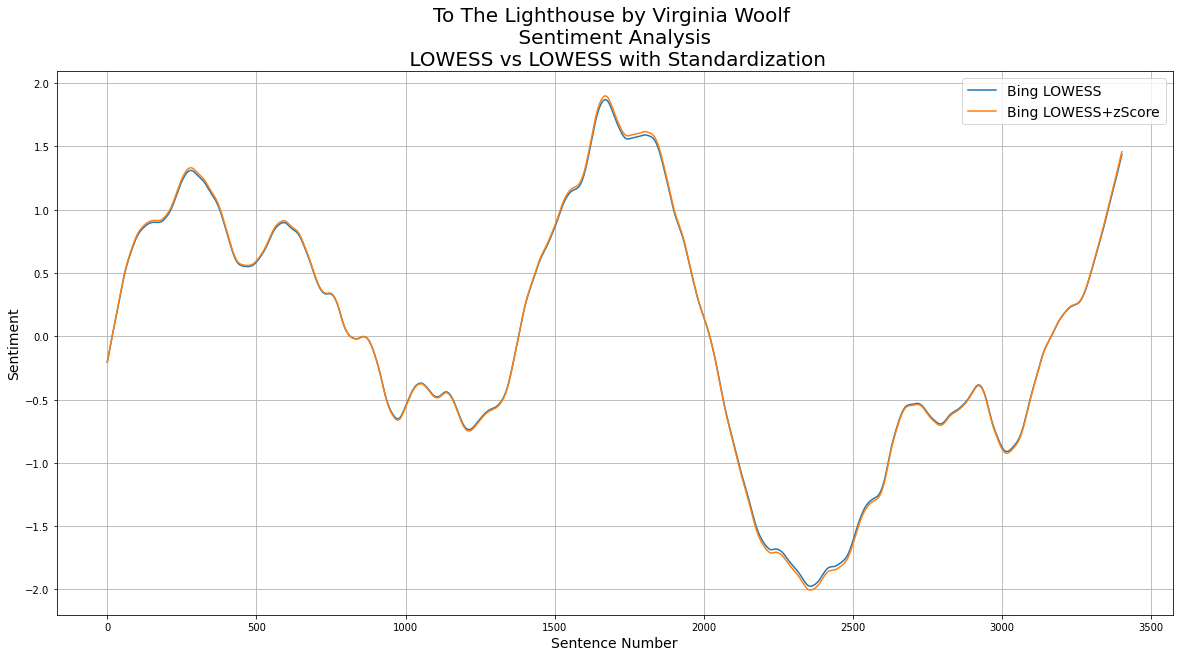

In [111]:
# EDA comparison for Bing LOWESS vs LOWESS+Standardization
#   Standardization NOT needed since LOWESS is smoothing an already Standardized SMA+STD Arc

subensemble_df['vader_lowess'].plot(label='Bing LOWESS')
subensemble_df['vader_stdlowess'].plot(label=f'Bing LOWESS+{Model_Standardization_Method}')
plt.title(f'{Novel_Title} \n Sentiment Analysis \n LOWESS vs LOWESS with Standardization', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show();

## EDA on Problem Calculating LOWESS for lmcd_sentimentr (too many zero values?)

In [ ]:
# NOTE: Can generally skip this section, 

# subensemble_df['lmcd_sentimentr_stdlowess'].max()

In [ ]:
# EDA comparison for Bing LOWESS vs LOWESS+Standardization
#   Not needed since LOWESS is smoothing an already Standardized SMA+STD Arc

"""
ensemble_df['lmcd_sentimentr_lowess'].plot(label='LMcD LOWESS')
ensemble_df['lmcd_sentimentr_stdlowess'].plot(label=f'LMcD LOWESS+{Model_Standardization_Method}')
plt.title(f'{Novel_Title[0]} \n Sentiment Analysis \n LOWESS vs LOWESS with Standardization')
plt.legend(loc='best')
""";

In [ ]:
# Add 3rd Pass of Smoothing from Original SMA->LOWESS->SMA

# ensemble_df['lmcd_sentimentr_stdlowess'].rolling(300, center=True, min_periods=0).mean().plot()

In [ ]:
# Distribution of Sentiment values 

# ensemble_df['lmcd_sentimentr'].plot(kind='hist', bins=30)

In [ ]:
# ensemble_df['lmcd_sentimentr_stdsma'].plot()
# ensemble_df['vader_stdsma'].plot()

## Plot Ensemble of Selected Models

Saved hi-res 300dpi Plot to: ./plots/plot_t_lowess30_of_zScore_SMA10_300dpi.png


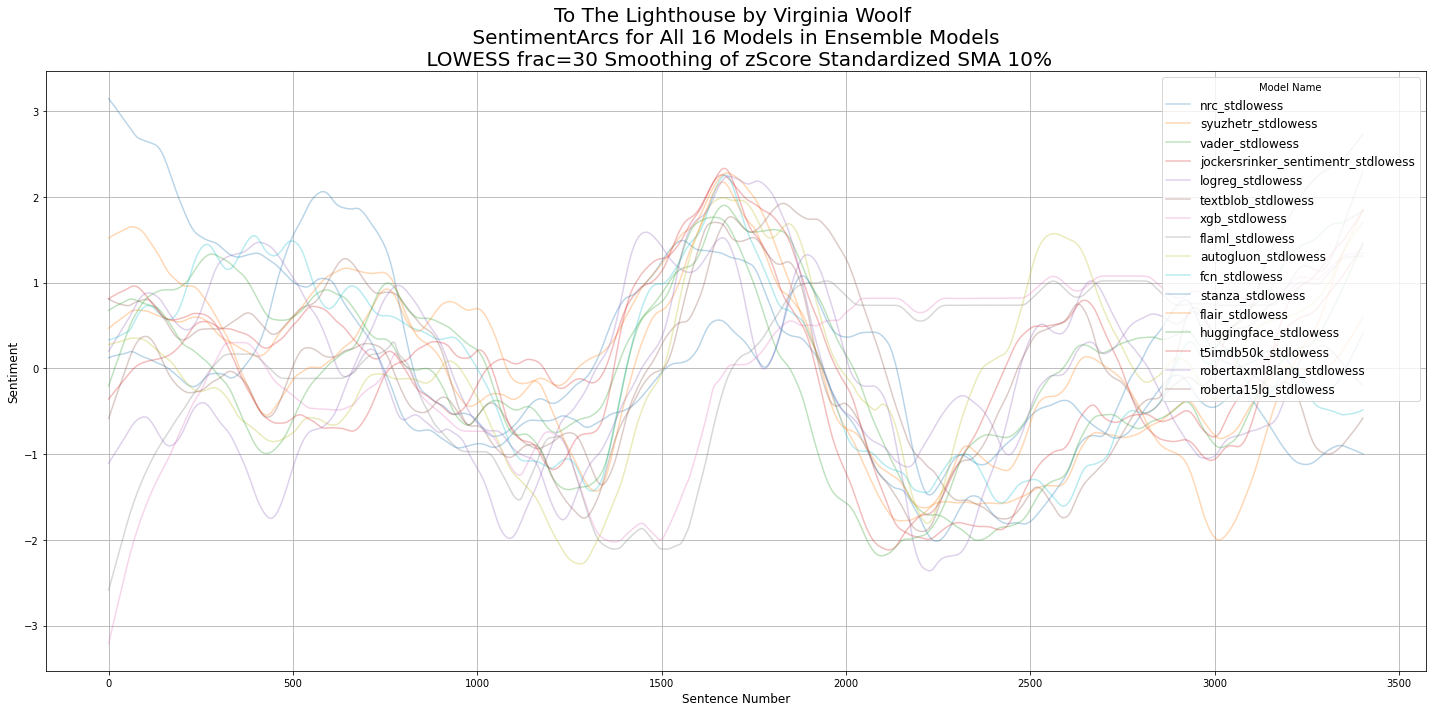

In [122]:
# EDA plot of All LOWESS Smoothed Standardized+SMA SentimentArcs by Model Family

#@markdown Confirm Ensemble SentimentArcs and Option to Saved:
Save_Plot = True #@param {type:"boolean"}
HiRes_300dpi = True #@param {type:"boolean"}

plt.figure(figsize=(20, 10))

stdlowess_ls = [x for x in subensemble_df.columns if x.endswith('_stdlowess')]

# ax, fig = plt.subplot()

for i, an_arc in enumerate(stdlowess_ls):
  subensemble_df[an_arc].plot(label=an_arc, alpha=0.3)

# plt.title(f'{Novel_Title[0]} \n Sentiment Analysis \n LOWESS with {Model_Standardization_Method} Standardization')

plt.grid(True)
plt.title(f'{Novel_Title} \n SentimentArcs for All {len(cols_ensemble_ls)} Models in Ensemble Models \n LOWESS frac={LOWESS_Fraction} Smoothing of {Model_Standardization_Method} Standardized SMA {Window_Percent}%', fontsize=20)
plt.xlabel('Sentence Number', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.legend(title='Model Name', loc='upper right', fontsize=12)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()

if Save_Plot:
  # get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)
  if HiRes_300dpi:
    # fig.set_size_inches(30.,18.)
    # figsize_tup = (40,20)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}_300dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=300)
    print(f'Saved hi-res 300dpi Plot to: {plot_fullpath}')
  else:
    # figsize_tup = (20,10)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}__100dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=100)
    print(f'Saved low-res 100dpi Plot to: {plot_fullpath}')

plt.show();


## Plot Individual Model within Ensemble

In [116]:
# Get list and string for all LOWESS smoothed SMA+STD Arcs

stdlowess_ls = [x for x in subensemble_df.columns if x.endswith('_stdlowess')]

stdlowess_str = ','.join([f"'{x}'" for x in stdlowess_ls if x.endswith('_stdlowess')])
stdlowess_str

"'nrc_stdlowess','syuzhetr_stdlowess','vader_stdlowess','jockersrinker_sentimentr_stdlowess','logreg_stdlowess','textblob_stdlowess','xgb_stdlowess','flaml_stdlowess','autogluon_stdlowess','fcn_stdlowess','stanza_stdlowess','flair_stdlowess','huggingface_stdlowess','t5imdb50k_stdlowess','robertaxml8lang_stdlowess','roberta15lg_stdlowess'"

Saved hi-res 300dpi Plot to: ./plots/plot_t_roberta15lg_stdlowess_lowess30_of_zScore_SMA10_300dpi.png


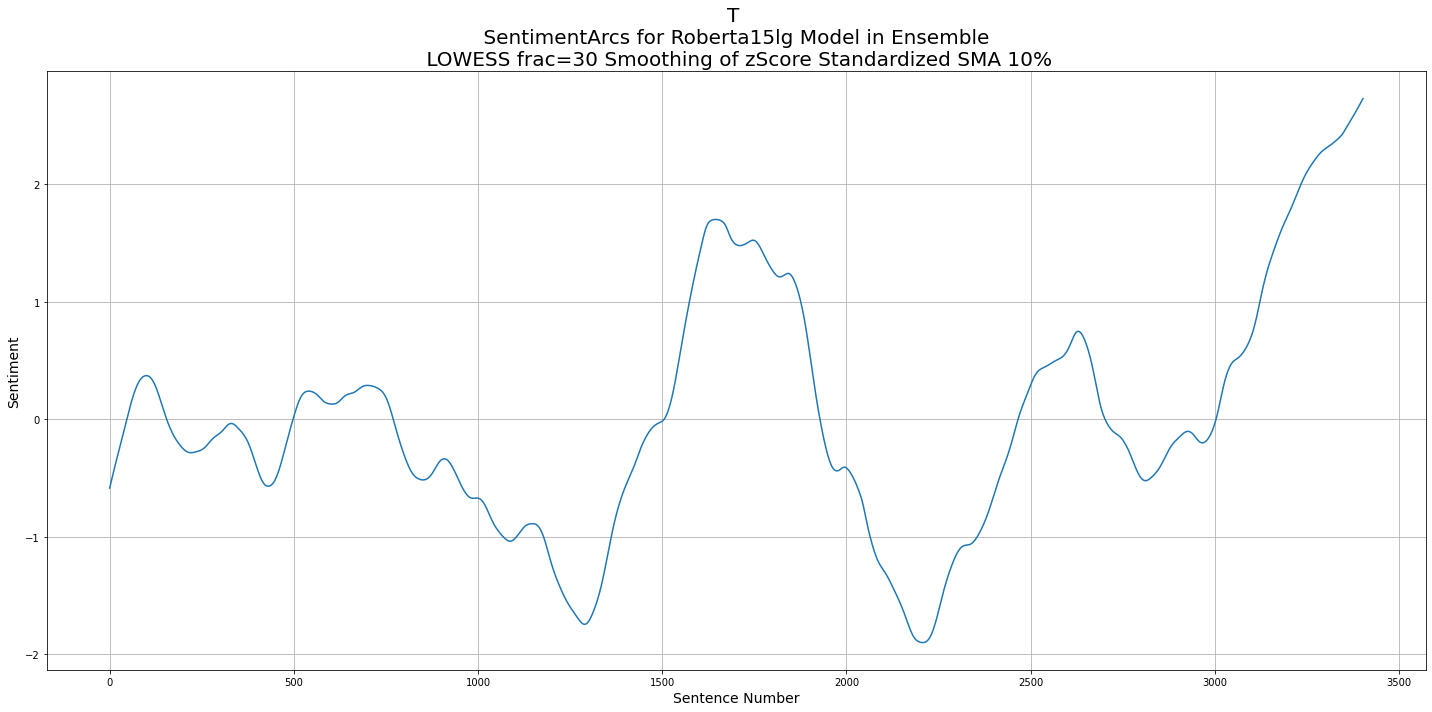

In [119]:
# EDA plot of LOWESS Smoothed Standardized+SMA SentimentArcs by Model Family

#@title Select which Model to Plot LOWESS Smoothed of SMA+STD:

Model_Name = "roberta15lg_stdlowess" #@param ['sentimentr_stdlowess','syuzhetr_stdlowess','bing_stdlowess','sentiword_sentimentr_stdlowess','senticnet_sentimentr_stdlowess','nrc_stdlowess','afinn_stdlowess','vader_stdlowess','textblob_stdlowess','pattern_stdlowess','stanza_stdlowess','flair_stdlowess','jockersrinker_sentimentr_stdlowess','jockers_sentimentr_stdlowess','bing_sentimentr_stdlowess','lmcd_sentimentr_stdlowess','roberta15lg_stdlowess','yelp_stdlowess','nlptown_stdlowess','huggingface_stdlowess','hinglish_stdlowess','imdb2way_stdlowess','t5imdb50k_stdlowess','robertaxml8lang_stdlowess','fcn_stdlowess','lstm_stdlowess','cnn_stdlowess','multinb_stdlowess','logreg_stdlowess','logreg_cv_stdlowess','rf_stdlowess','xgb_stdlowess','flaml_stdlowess','autogluon_stdlowess','median_stdlowess']

# Novel_Name = {Novel_Title[0]} #@param [Novel_Title[0]]

#@markdown Confirm Ensemble SentimentArcs and Option to Saved:
Save_Plot = True #@param {type:"boolean"}
HiRes_300dpi = True #@param {type:"boolean"}


plt.figure(figsize=(20,10))

subensemble_df[Model_Name].plot()

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {" ".join(Model_Name.split("_")[:-1]).capitalize()} Model in Ensemble \n LOWESS frac={LOWESS_Fraction} Smoothing of {Model_Standardization_Method} Standardized SMA {Window_Percent}%', fontsize=20)
plt.xlabel('Sentence Number', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
# plt.legend(title='Model Name', loc='best')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()

if Save_Plot:
  # get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)
  if HiRes_300dpi:
    # fig.set_size_inches(30.,18.)
    # figsize_tup = (40,20)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'{Model_Name.lower()}', last_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}_300dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=300)
    print(f'Saved hi-res 300dpi Plot to: {plot_fullpath}')
  else:
    # figsize_tup = (20,10)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'{Model_Name.lower()}', last_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}__100dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=100)
    print(f'Saved low-res 100dpi Plot to: {plot_fullpath}')

plt.show();


## Plot Model Families within Ensemble

Saved hi-res 300dpi Plot to: ./plots/plot_t_lowess30_of_zScore_SMA10_300dpi.png


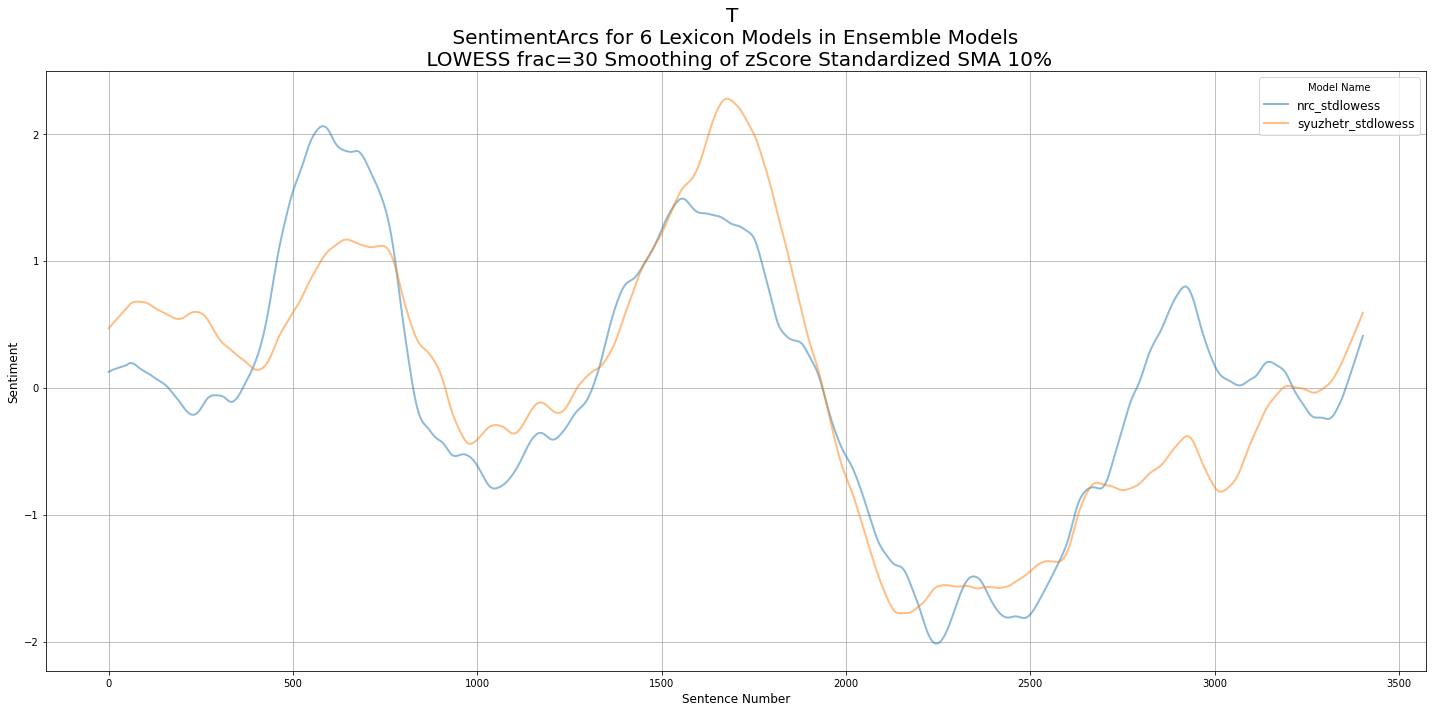

In [124]:
# EDA plot of LOWESS Smoothed Standardized+SMA SentimentArcs by Model Family

#@title Select which Model Family to Plot LOWESS Smoothed of SMA+STD:

Model_Family = "lexicon" #@param ["lexicon", "heuristic", "tradml", "dnn", "transformer"]

#@markdown Confirm Ensemble SentimentArcs and Option to Saved:
Save_Plot = True #@param {type:"boolean"}
HiRes_300dpi = True #@param {type:"boolean"}

stdlowess_ls = [x for x in subensemble_df.columns if x.endswith('_stdlowess')]

# Select which family to Plot
plot_family = ['lexicon','heuristic','tradml','dnn','transformer']

plt.figure(figsize=(20,10))

# Plot the LOWESS+Standardized (*_stdlowess columns) SentimentArcs for Ensemble Models
for acol in cols_ensemble_ls:
  # print(f'Processing Model: {acol}')
  if (acol in models_lexicon_ls) & (Model_Family == 'lexicon'):
    cols_family_ls = models_lexicon_ls
    alinestyle = 'solid'
    acol_stdlowess = f'{acol}_stdlowess'
    subensemble_df[acol_stdlowess].plot(alpha=0.5, label=acol_stdlowess, linewidth=2, linestyle=alinestyle)
  elif (acol in models_heuristic_ls) & (Model_Family == 'heuristic'):
    cols_family_ls = models_heuristic_ls
    alinestyle = 'solid'
    # Catch exception with LOWESS error on lmcd_sentimentr (too many zero values?)
    # BUGFIX for lmcd_sentimentr, works with LOWESS smoothing of STD+SMA
    # if acol.startswith('lmcd_sentimentr'):
    if acol.startswith('execute_else_stmt'):
      # Keep this error check inplace in case future novels/models/params replicate this problem
      continue
    else:
      acol_stdlowess = f'{acol}_stdlowess'
      subensemble_df[acol_stdlowess].plot(alpha=0.5, label=acol_stdlowess, linewidth=2, linestyle=alinestyle)
  elif (acol in models_tradml_ls) & (Model_Family == 'tradml'):
    cols_family_ls = models_tradml_ls
    alinestyle = 'dashdot'
    acol_stdlowess = f'{acol}_stdlowess'
    subensemble_df[acol_stdlowess].plot(alpha=0.5, label=acol_stdlowess, linewidth=2, linestyle=alinestyle)
  elif (acol in models_dnn_ls) & (Model_Family == 'dnn'):
    cols_family_ls = models_dnn_ls
    alinestyle = 'dotted'
    acol_stdlowess = f'{acol}_stdlowess'
    subensemble_df[acol_stdlowess].plot(alpha=0.5, label=acol_stdlowess, linewidth=2, linestyle=alinestyle)  
  elif (acol in models_transformer_ls) & (Model_Family == 'transformer'):
    cols_family_ls = models_transformer_ls
    alinestyle='dashed'
    acol_stdlowess = f'{acol}_stdlowess'
    subensemble_df[acol_stdlowess].plot(alpha=0.5, label=acol_stdlowess, linewidth=2, linestyle=alinestyle)

plt.grid(True)
plt.title(f'{Novel_Title[0]} \n SentimentArcs for {len(cols_family_ls)} {Model_Family.capitalize()} Models in Ensemble Models \n LOWESS frac={LOWESS_Fraction} Smoothing of {Model_Standardization_Method} Standardized SMA {Window_Percent}%', fontsize=20)
plt.xlabel('Sentence Number', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.legend(title='Model Name', loc='best', fontsize=12)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Model Name')
plt.tight_layout()

if Save_Plot:
  # get_fullpath(ftype='data_clean', first_note='vader', last_note='anote bnote', plot_ext='png', no_date=True)
  if HiRes_300dpi:
    # fig.set_size_inches(30.,18.)
    # figsize_tup = (40,20)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}_300dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=300)
    print(f'Saved hi-res 300dpi Plot to: {plot_fullpath}')
  else:
    # figsize_tup = (20,10)
    # figsize_str = f'figsize_{figsize_tup[0]}_{figsize_tup[1]}'
    # plt.figure(figsize=figsize_tup)
    plot_fullpath = get_fullpath(ftype='plot', first_note=f'lowess{LOWESS_Fraction}_of_{Model_Standardization_Method}_SMA{Window_Percent}__100dpi', no_date=True) # last_note=figsize_str, no_date=True)
    plt.savefig(plot_fullpath, dpi=100)
    print(f'Saved low-res 100dpi Plot to: {plot_fullpath}')

plt.show();


# Save Checkpoint

In [ ]:
!pwd

In [ ]:
!ls

In [125]:
# Save newly cleaned (Smoothed then Standardized) Ensemble Model data

file_fullpath = get_fullpath(ftype='data_clean')
ensemble_df.to_csv(file_fullpath)

print(f'Saved to file: {file_fullpath}')

Saved to file: ./data/sentiments_clean/sa_clean_t_zscore_sma10_2021_11_28-11_14_16_PM.csv


In [126]:
# Verify saved file contents

!head -n 10 $file_fullpath

,sent_no,parag_no,sect_no,sent_raw,sentimentr,syuzhetr,bing,sentiword_sentimentr,senticnet_sentimentr,nrc,afinn,vader,textblob,pattern,stanza,flair,jockersrinker_sentimentr,jockers_sentimentr,bing_sentimentr,lmcd_sentimentr,roberta15lg,yelp,nlptown,huggingface,hinglish,imdb2way,t5imdb50k,robertaxml8lang,fcn,lstm,cnn,sent_clean,multinb,logreg,logreg_cv,rf,xgb,flaml,autogluon,huggingface_z,pattern_z,t5imdb50k_z,rf_z,robertaxml8lang_z,flaml_z,jockers_z,vader_z,cnn_z,lmcd_z,stanza_z,jockers_rinker_z,textblob_z,imdb2way_z,senticnet_z,logreg_z,huliu_z,hinglish_z,fcn_z,logreg_cv_z,lstm_z,roberta15lg_z,nrc_z,afinn_z,flair_z,bing_z,xgb_z,syuzhet_z,sentimentr_z,nlptown_z,yelp_z,sentiword_z,multinb_z,autogluon_z,median_z,median
0,0,0,0,"""Yes, of course, if it's fine tomorrow,"" said Mrs. Ramsay.",1.05,1.05,29.429982966380248,0.25,-0.7019999999999998,0.0,1.20101112030975,0.5423,0.4166666666666667,0.17304185583720652,4.804044481239,0.982,0.316586911806652,0.316586911806652,0.301511344577764,0.0,0.

# Explore Cruxes

In [129]:
def get_crux_context(adf=subensemble_df, acol_sentraw='sent_raw', asent_no=5, ahalf_win=2, do_upper=True):
  '''
  Given a DataFrame with acol_sentraw of Sentence raw text along with
    a crux sent_no and half_win number of sentences on before and after crux point
  Return a list of Sentences that define the (2*ahalf_win + 1) context window around the Crux asent_no
  '''

  context_ls = []

  corpus_len = adf.shape[0]

  # Get lower bound of Crux Context Window
  context_min = asent_no - ahalf_win
  if context_min < 0:
    context_min = 0

  # Get upper bound of Crux Context Window
  context_max = asent_no + ahalf_win + 1 # correct for zero-based indexing 
  if context_max > corpus_len:
    context_max = corpus_len - 1

  lineno_ls = list(range(context_min,context_max))
  context_ls = adf.iloc[context_min:context_max][acol_sentraw].to_list()

  if do_upper:
    # [f(x) if condition else g(x) for x in sequence]
    crux_str = adf.iloc[asent_no][acol_sentraw]
    context_ls = [x.upper() if x == crux_str else x for x in context_ls]

  context_tup_ls = list(zip(lineno_ls, context_ls))

  return context_tup_ls

# Test

temp_tup_ls = get_crux_context(subensemble_df, 'sent_raw', 20, 5)
temp_tup_ls

[(15,
  'she would ask; and to have no letters or newspapers, and to see nobody; if you were married, not to see your wife, not to know how your children were, - if they were ill, if they had fallen down and broken their legs or arms; to see the same dreary waves breaking week after week, and then a dreadful storm coming, and the windows covered with spray, and birds dashed against the lamp, and the whole place rocking, and not be able to put your nose out of doors for fear of being swept into the sea?'),
 (16, 'How would you like that?'),
 (17, 'she asked, addressing herself particularly to her daughters.'),
 (18,
  'So she added, rather differently, one must take them whatever comforts one can.'),
 (19,
  '"It\'s due west," said the atheist Tansley, holding his bony fingers spread so that the wind blew through them, for he was sharing Mr. Ramsay\'s evening walk up and down, up and down the terrace.'),
 (20,
  'THAT IS TO SAY, THE WIND BLEW FROM THE WORST POSSIBLE DIRECTION FOR LANDIN

In [137]:
def get_crux_points(adf, acol_name, text_type='sentence', win_per=5, sec_y_labels=True, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  # print('entered get_crux_points') 
  crux_ls = []

  series_len = adf.shape[0]
  # print(f'series_len = {series_len}')

  # sent_no_min = adf[].min()
  sent_no_min = 0
  # sent_no_max = adf.sent_no.max()
  sent_no_max = series_len - 1
  # print(f'sent_no_min {sent_no_min}')

  sm_x = adf.index.values
  sm_y = adf[acol_name].values.flatten()

  half_win = int((win_per/100)*series_len)
  # print(f'half_win = {half_win}')
  # print(f'sm_y type = {type(sm_y)}')

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  # print(f'peak_indexes type = {type(peak_indexes)}') # sent_no_start sent
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_x_adj_ls = [x+sent_no_min for x in peak_x_ls]

  peak_y_ls = list(sm_y[peak_indexes])

  peak_label_ls = ['peak'] * len(peak_y_ls)
  peak_coord_ls = tuple(zip(peak_label_ls, peak_x_adj_ls, peak_y_ls))

  # peak_y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_x_adj_ls = [x+sent_no_min for x in valley_x_ls]

  valley_y_ls = list(sm_y[valley_indexes])

  valley_label_ls = ['valley'] * len(valley_y_ls)
  valley_coord_ls = tuple(zip(valley_label_ls, valley_x_adj_ls, valley_y_ls))

  # Combine Peaks and Valley Coordinates into List of Tuples(label, x_coord, y_coord)
  crux_coord_ls = peak_coord_ls + valley_coord_ls

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  #  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  #  x_all_ls = [x+sent_no_min for x in x_all_ls]
  #  y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:

    plt.figure(figsize=(20,10))

    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    # corpus_sects_df
    if sec_y_labels == True:
      section_sent_no_boundries_ls = list(corpus_sects_df['sent_no_start'])
      section_no_ls = list(corpus_sects_df['sect_no'])
      for i, asect_no in enumerate(section_sent_no_boundries_ls):
        # Plot vertical lines for section boundries
        plt.text(asect_no, sec_y_height, f'Section #{section_no_ls[i]}', alpha=0.2, rotation=90)
        plt.axvline(asect_no, color='blue', alpha=0.1)    


    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, ha='center', va='bottom', annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, ha='center', va='top', annotation_clip=True) # xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')
    plt.suptitle(f'{Novel_Title} \n SentimentArc Crux Detection for Model: {acol_name} \n SMA ({Window_Percent}%) Smoothed then Standardized ({Model_Standardization_Method}) \n {subtitle_str}', fontsize=20, y=1.05);    
    # plt.title(f'{Novel_Title[0]} \n SentimentArc Crux Detection for Model: {acol_name} \n SMA ({Window_Percent}%) Smoothed then Standardized ({Model_Standardization_Method}) \n {subtitle_str}')
    plt.xlabel(f'Sentence No', fontsize=12) # within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value', fontsize=12)
    # plt.legend(loc='best');
    plt.grid(True)

  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n SMA Smoothed Sentence Sentiment Arcs Crux Points')
    # plt.legend(loc='best')
    plt.savefig(f"{CORPUS_FILENAME.split('.')[0]}_find_peaks.png")

  return crux_coord_ls;

<Figure size 1440x720 with 0 Axes>

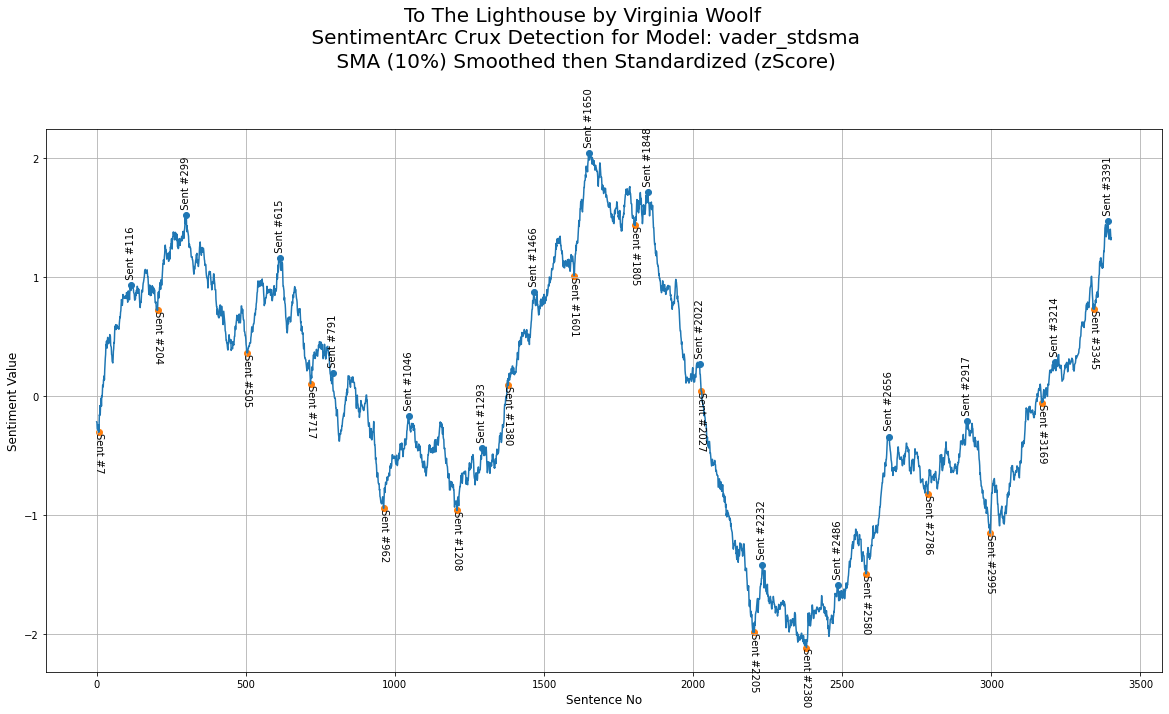

In [138]:
# Test

crux_tup_ls = get_crux_points(subensemble_df, 'vader_stdsma', text_type='sentence', win_per=5, sec_y_labels=False, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False)

In [ ]:
# [SKIP] to next section

In [ ]:
def crux_sortsents_report(crux_ls, ts_df=ensemble_df, library_type='baseline', top_n=3, get_peaks=True, sort_by='sent_no', n_sideparags=1, sentence_highlight=True):
  '''
  Wrapper function to produce report based upon 'crux_sortsents() described as:
    Given a list of tuples (sent_no, sentiment value), top_n cruxes to retrieve and bool flag get_peaks
    Return a sorted list of peaks/valleys (sentiment_value, sent_no, sent_raw) from greatest down for top_n items

    # get_sentnocontext_report
  '''

  if get_peaks == True:
    crux_label = 'Peak'
  else:
    crux_label = 'Valley'

  # Filter and keep only the desired crux type in List crux_subset_ls
  crux_subset_ls = []
  for acrux_tup in crux_ls:
    crux_type, crux_x_coord, crux_y_coord = acrux_tup
    if crux_type.lower() == crux_label.lower():
      crux_subset_ls.append((crux_x_coord,crux_y_coord)) # Append a Tuple to List

  flag_2few_cruxes = False

  # Check to see if asked for more Cruxes than were found 
  top_n_found = len(crux_subset_ls)
  if top_n_found < top_n:
    flag_2few_cruxes = True
    print(f'\n\nWARNING: You asked for {top_n} {crux_label}s\n         but there only {top_n_found} were found above.\n')
    print(f'             Displaying as many {crux_label}s as possible,')
    print(f'             to retrieve more, go back to the previous code cells and re-run with wider Crux Window.\n\n')


  # Get Sentence no and raw text for appropriate Crux subset
  # print(f'Calling crux_n_top_ls with crux_subset_ls={crux_subset_ls}\ntop_n={top_n}\nget_peaks={get_peaks}')
  crux_n_top_ls = crux_sortsents(corpus_df = ts_df, crux_ls=crux_subset_ls, atop_n=top_n, get_peaks=get_peaks, sort_key=sort_by)
  # print(f'Returning crux_n_top_ls = {crux_n_top_ls}')

  # Print appropriate header Select_Section_No sent_no
  print('------------------------------')
  # print(f'library_type: {library_type}')
  if library_type in ['baseline','sentimentr','syuzhetr','transformer','unified']:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Library: {library_type.capitalize()} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Library #{library_type.capitalize()} ONLY Top {top_n_found} {crux_label}s Found\n')
  else:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Section #{Select_Section_No} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Section #{Select_Section_No} ONLY Top {top_n_found} {crux_label}s Found\n')

  # Print summary of subset Cruxes
  for i,crux_sent_tup in enumerate(crux_n_top_ls):
    # crux_type, crux_x_coord, crux_y_coord = crux_sent_tup
    crux_x_coord, crux_y_coord, crux_sent_raw = crux_sent_tup
    print(f'   {crux_label} #{i} at Sentence #{crux_x_coord} with Sentiment Value {crux_y_coord}')
  # print('------------------------------\n')
  # print('Sent_No  Sentiment   Sentence (Raw Text)\n')
  
  # Print details of each Crux in subset
  for sent_no, sent_pol, sent_raw in crux_n_top_ls: 
    sent_no = int(sent_no)
    print('\n\n-------------------------------------------------------------')
    print(f'Sentence #{sent_no}   Sentiment: {sent_pol:.3f}\n') #     {sent_raw}\n')
    # print('------------------------------')
    get_sentnocontext_report(ts_df=ts_df, the_sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)
    # get_sentnocontext(sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)


In [ ]:
def get_lowess_cruxes(ts_df, col_series, text_type='sentence', win_lowess=5, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  crux_ls = []

  series_len = ts_df.shape[0]

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values

  half_win = int((win_lowess/100)*series_len)

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_y_ls = list(sm_y[peak_indexes])

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_y_ls = list(sm_y[valley_indexes])

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  x_all_ls = [x+sent_no_min for x in x_all_ls]
  y_all_ls = peak_y_ls + valley_y_ls
  crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    if text_type == 'sentence':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(sent_no, sec_y_height, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
          plt.axvline(sent_no, color='blue', alpha=0.1)
    elif text_type == 'paragraph':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag_no in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(aparag_no, sec_y_height, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
          plt.axvline(aparag_no, color='blue', alpha=0.1)    
    else:
      print(f"ERROR: text_type is {text_type} but must be either 'sentence' or 'paragarph'")

    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} Raw Sentence Crux Detection in Section #{Select_Section_No}\nLOWESS Smoothed {subtitle_str} and SciPy find_peaks')
    plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Crux Points via SciPy.argrelextrema')
    plt.legend(loc='best')
    plt.savefig('argrelextrema.png')

  return crux_coord_ls

## Search Corpus for Substring

INSTRUCTIONS:

* In [Search_for_Substring] enter a Substring to search for in the Corpus

* Enter a Substring long enough/unique enough so only a reasonable number of Sentences will be returned

* Substring can contain spaces/punctuation, for example: 'in the garden'

In [139]:
# Search Corpus Sentences for Substring

Search_for_Substring = "abuse" #@param {type:"string"}

match_sentno_ls = subensemble_df[subensemble_df['sent_raw'].str.contains(Search_for_Substring, regex=False)]['sent_no']

for i, asentno in enumerate(match_sentno_ls):
  # sentno, sentraw = asent
  print(f"\n\nMatch #{i}: Sentence #{asentno}\n\n")
  sent_highlight = re.sub(Search_for_Substring, Search_for_Substring.upper(), ensemble_df.iloc[asentno]['sent_raw'])
  print(f'    {sent_highlight}')



Match #0: Sentence #1448


    Probably, Mr. Bankes thought, as Tansley ABUSEd the government, there is a good deal in what he says.


Match #1: Sentence #2839


    Oh, Mrs. Ramsay! she called out silently, to that essence which sat by the boat, that abstract one made of her, that woman in grey, as if to ABUSE her for having gone, and then having gone, come back again.


In [140]:
# Get Context around Matching Sentences

#@title Get Context Around Each Matching Sentence:

# Context Details
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Sentence = True #@param {type:"boolean"}

crux_context_dt = {}
for i, asent_no in enumerate(match_sentno_ls):
  crux_tup_ls = get_crux_context(adf=subensemble_df, acol_sentraw='sent_raw', asent_no=asent_no, ahalf_win=No_Paragraphs_on_Each_Side, do_upper=Highlight_Sentence)
  crux_context_dt[asent_no] = crux_tup_ls


for key, val in crux_context_dt.items():
  print(f'\nCrux No: {key}')
  for aval in val:
    alineno, asent = aval
    print(f'  Line #{alineno}: {asent}')
  print('\n')



Crux No: 1448
  Line #1445: Poor old fogies, you're hopelessly behind the times.
  Line #1446: He seemed to be rather cocksure, this young man; and his manners were bad.
  Line #1447: But Mr. Bankes bade himself observe, he had courage; he had ability; he was extremely well up in the facts.
  Line #1448: PROBABLY, MR. BANKES THOUGHT, AS TANSLEY ABUSED THE GOVERNMENT, THERE IS A GOOD DEAL IN WHAT HE SAYS.
  Line #1449: "Tell me now..." he said.
  Line #1450: So they argued about politics, and Lily looked at the leaf on the table-cloth; and Mrs. Ramsay, leaving the argument entirely in the hands of the two men, wondered why she was so bored by this talk, and wished, looking at her husband at the other end of the table, that he would say something.
  Line #1451: One word, she said to herself.



Crux No: 2839
  Line #2836: The physical sensations that went with the bare look of the steps had become suddenly extremely unpleasant.
  Line #2837: To want and not to have, sent all up her body

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [143]:
%whos list

Variable                   Type    Data/Info
--------------------------------------------
Model_Title                list    n=3
afrac_ls                   list    n=4
allz_filenames_ls          list    n=25
allz_filenames_quoted_ls   list    n=25
cols_drop_set              list    n=18
cols_ensemble_ls           list    n=16
cols_ensemble_title_ls     list    n=16
cols_family_ls             list    n=6
cols_missing_ls            list    n=1
cols_model_deriv_drop_ls   list    n=35
cols_suffix_ls             list    n=5
crux_tup_ls                list    n=7
ensemble_dnn_ls            list    n=3
ensemble_heuristic_ls      list    n=2
ensemble_lexicon_ls        list    n=2
ensemble_tradml_ls         list    n=5
ensemble_transformer_ls    list    n=4
models_dnn_ls              list    n=5
models_ensemble_ls         list    n=35
models_ensemble_title_ls   list    n=16
models_heuristic_ls        list    n=7
models_lexicon_ls          list    n=6
models_subensemble_ls      list    n=17
mode

In [144]:
# Generate the list of Model names currently selected to be in the Ensemble
#   need to paste into drop down below

# TODO: Automatically generate values for all models, not just those selected to be in Ensemble

temp_ls = []

for acol in models_subensemble_ls:
  temp_ls.append(f"'{acol}'")

temp_str = ','.join(temp_ls)
temp_str

"'nrc','syuzhetr','vader','jockersrinker_sentimentr','logreg','textblob','xgb','flaml','autogluon','fcn','stanza','flair','huggingface','t5imdb50k','robertaxml8lang','roberta15lg','median'"

<Figure size 1440x720 with 0 Axes>

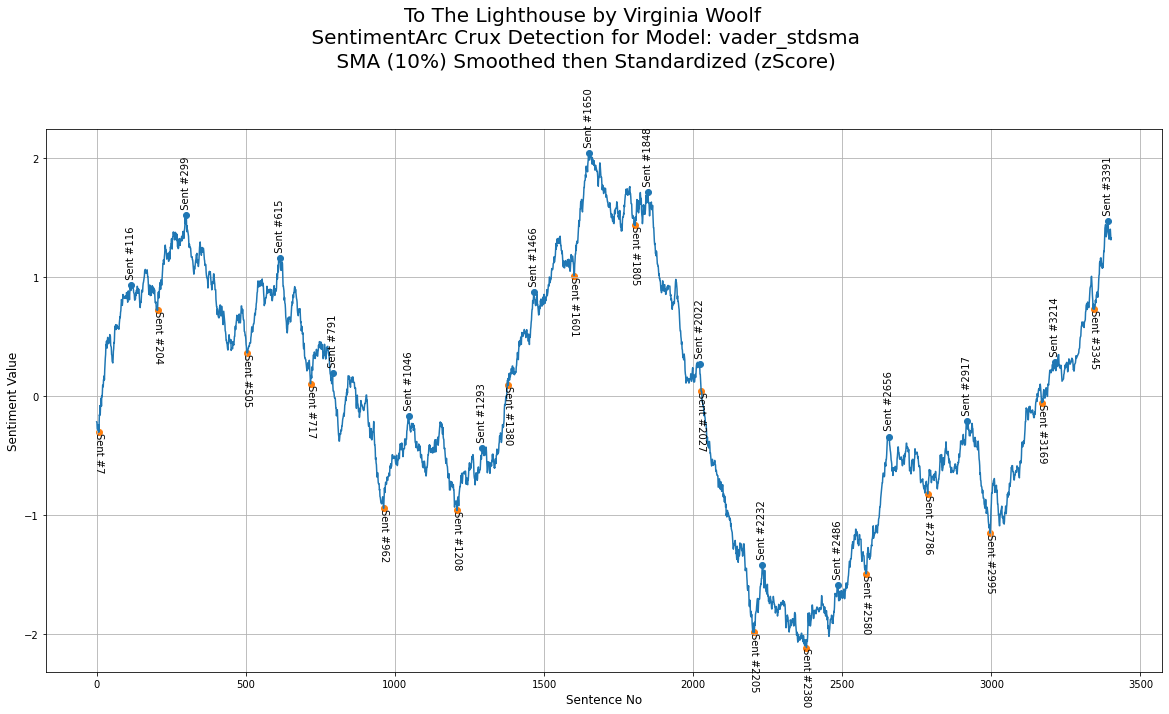

In [147]:
Crux_Window_Percent = 5 #@param {type:"slider", min:1, max:20, step:1}
Model_Name = "vader" #@param ['afinn','bing','nrc','syuzhetr','sentimentr','pattern','vader','bing_sentimentr','sentiword_sentimentr','senticnet_sentimentr','lmcd_sentimentr','jockers_sentimentr','jockersrinker_sentimentr','logreg','logreg_cv','multinb','textblob','rf','xgb','flaml','autogluon','fcn','lstm','cnn','stanza','flair','huggingface','t5imdb50k','hinglish','yelp','imdb2way','nlptown','robertaxml8lang','roberta15lg','median']
# Anomaly_Detection = False #@param {type:"boolean"}
# Vertical_Labels = True #@param {type:"boolean"}
# Vertical_Labels_Height = -0.1 #@param {type:"slider", min:-50, max:50, step:0.1}
# Save_to_Report = False #@param {type:"boolean"}

amodel_stdsma = f'{Model_Name}_stdsma'

if Model_Name in models_subensemble_ls:
  crux_tup_ls = get_crux_points(subensemble_df, amodel_stdsma, text_type='sentence', win_per=5, sec_y_labels=False, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False)
else:
  print(f'ERROR: {Model_Name} was not selected as part of SubEnsemble\n  Either change Model_Name or go back and add this Model')

## Context around Top-n Crux Peaks/Valleys

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
crux_tup_ls

In [150]:
#@title Get Context around Crux Points:

#@markdown Crux Point Details
# Get_Peak_Cruxes = False #@param {type:"boolean"}
Get_n_Cruxes = 20 #@param {type:"slider", min:1, max:30, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

#@markdown Context Details
No_Paragraphs_on_Each_Side = 5 #@param {type:"slider", min:0, max:15, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
# Save_to_Report = False #@param {type:"boolean"}


if Sort_by_SentenceNo == True:
  sort_on = 'sent_no'
else:
  sort_on = Model_Name  # Selected in previous code cell


crux_context_dt = {}
crux_peaks_dt = {}
crux_valleys_dt = {}
for i, acrux_tup in enumerate(crux_tup_ls):
  crux_type, crux_sentno, crux_sentiment = acrux_tup
  acrux_ls = get_crux_context(adf=subensemble_df, acol_sentraw='sent_raw', asent_no=crux_sentno, ahalf_win=No_Paragraphs_on_Each_Side, do_upper=Highlight_Sentence)
  if crux_type == 'peak':
    if Sort_by_SentenceNo:
      crux_peaks_dt[crux_sentno] = ['peak', crux_sentno, crux_sentiment, acrux_ls]
    else:
      crux_peaks_dt[crux_sentiment] = ['peak', crux_sentno, crux_sentiment, acrux_ls]
  elif crux_type == 'valley':
    if Sort_by_SentenceNo:
      crux_valleys_dt[crux_sentno] = ['valley', crux_sentno, crux_sentiment, acrux_ls]
    else:
      crux_valleys_dt[crux_sentiment] = ['valley', crux_sentno, crux_sentiment, acrux_ls]

if Sort_by_SentenceNo:
  print(f'\n\n{Novel_Title} \nCrux Peaks sorted by Sentence No\n====================\n')
  for key, val in crux_peaks_dt.items():
    # print(f'\nCrux at Sentence No: {key}')
    acrux_type, acrux_sentno, acrux_sentiment, acrux_ls = val
    print(f'\n{acrux_type.capitalize()} Crux at Sentence No: {key}  (Sentiment: {acrux_sentiment:.3f})')
    for acrux_sent in acrux_ls:
      print(f'    {acrux_sent}')
  print(f'\n\n{Novel_Title} \nCrux Valleys sorted by Sentence No\n====================\n')
  for key, val in crux_valleys_dt.items():
    # print(f'\nCrux at Sentence No: {key}')
    acrux_type, acrux_sentno, acrux_sentiment, acrux_ls = val
    print(f'\n{acrux_type.capitalize()} Crux at Sentence No: {key}  (Sentiment: {acrux_sentiment:.3f})')
    for acrux_sent in acrux_ls:
      print(f'    {acrux_sent}')

"""
else:
  for key, val in crux_peaks_dt.items():
    print(f'\nCrux at Polarity: {key}')
    acrux_sentno, acrux_sentiment, acrux_ls = val
    print(f'  Sentiment: {acrux_sentiment}')
    for acrux_sent in acrux_ls:
      print(f'    {acrux_sent}')



    for aval in val:
      acrux_sentno, acrux_sentiment, acrux_ls = aval
      print(f'  Sentiment: {acrux_sentiment}')
      for aline 
      print(f'  Line #{alineno}: {asent}')
    print('\n')


print(f'Crux Report --------------------\n')
print(f'            Corpus: {CORPUS_FULL}')
print(f'            Model: {Baseline_SMA_Model}')
print(f'            Crux Win%: {Crux_Window_Percent}')
print(f'            SMA Win%: {sma_str}')

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        ts_df = corpus_sents_df,
                        library_type='baseline', 
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes,
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # import sys
  # with open('filename.txt', 'w') as f:
  #   print('This message will be written to a file.', file=f)
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__
""";



To The Lighthouse by Virginia Woolf 
Crux Peaks sorted by Sentence No


Peak Crux at Sentence No: 116  (Sentiment: 0.930)
    (111, 'What he would have liked, she supposed, would have been to say how he had gone not to the circus but to Ibsen with the Ramsays.')
    (112, 'He was an awful prig - oh yes, an insufferable bore.')
    (113, 'For, though they had reached the town now and were in the main street, with carts grinding past on the cobbles, still he went on talking, about settlements, and teaching, and working men, and helping our own class, and lectures, till she gathered that he had got back entire self-confidence, had recovered from the circus, and was about (and now again she liked him warmly) to tell her - but here, the houses falling away on both sides, they came out on the quay, and the whole bay spread before them and Mrs. Ramsay could not help exclaiming, "Oh, how beautiful!"')
    (114, 'For the great plateful of blue water was before her; the hoary Lighthouse, dista

### Save Crux to File


In [161]:
%%capture cap --no-stderr

# Print Context around each Sentiment Peak

"""
novel_sent_len = novel_df.shape[0]
halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'
""";

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

if Sort_by_SentenceNo:
  # print(f'\n\n{Novel_Title[0]} \nCrux Peaks sorted by Sentence No\n====================\n')
  for key, val in crux_peaks_dt.items():
    # print(f'\nCrux at Sentence No: {key}')
    acrux_type, acrux_sentno, acrux_sentiment, acrux_ls = val
    print(f'\n{acrux_type.capitalize()} Crux at Sentence No: {key}  (Sentiment: {acrux_sentiment:.3f})')
    for acrux_sent in acrux_ls:
      print(f'    {acrux_sent}')


"""
# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  crux_sents_ls = []
  win_start = max(0, apeak-halfwin)
  win_end = min(apeak+halfwin+1, novel_sent_len)
  # for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
  for sent_idx in range(win_start,win_end):

    sent_cur = novel_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = novel_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
""";


print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

if Sort_by_SentenceNo:
  # print(f'\n\n{Novel_Title[0]} \nCrux Valleys sorted by Sentence No\n====================\n')
  for key, val in crux_valleys_dt.items():
    # print(f'\nCrux at Sentence No: {key}')
    acrux_type, acrux_sentno, acrux_sentiment, acrux_ls = val
    print(f'\n{acrux_type.capitalize()} Crux at Sentence No: {key}  (Sentiment: {acrux_sentiment:.3f})')
    for acrux_sent in acrux_ls:
      print(f'    {acrux_sent}')

"""
# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  crux_sents_ls = []
  win_start = max(0, avalley-halfwin)
  win_end = min(avalley+halfwin+1, novel_sent_len)
  # for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
  for sent_idx in range(win_start,win_end):
    sent_cur = novel_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
""";

# Save newly cleaned (Smoothed then Standardized) Ensemble Model data

file_fullpath = get_fullpath(ftype='crux_text')
# ensemble_df.to_csv(file_fullpath)

# print(f'Saved to file: {file_fullpath}')

# filename_cruxes = f"cruxes_context_{Novel_Title[0].replace(' ', '_')}.txt" 

with open(file_fullpath, 'w') as f:
    f.write(str(cap))

In [162]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

print(f'Downloading crux text file: {file_fullpath}')
files.download(file_fullpath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **END OF NOTEBOOK**

# **CONTENT OF NEXT NOTEBOOK**

# Smooth, Dimensionally Reduce and Cluster SentimentArcs

# Get Correlation Heatmaps of SentimentArcs

# Get SentimentArcs Metrics and Plot

# Summarize